In [89]:
library(rstanarm)
library(ggformula)
library(tibble)
library(glue)
library(dplyr)
library(stringr)

In [90]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [91]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

# Regression predictors
In the election forecasting example of Section 7.1, we used inflation-adjusted growth in average personal income as a predictor.
From the standpoint of economics, it makes sense to adjust for inflation here.
But suppose the model had used growth in average personal income, not adjusting for inflation.
How would this have changed the resulting regression?
How would this have affected the fit and interpretation of the results?

## Answer

Inflation roughly adds an extra few percentage points (say 2-3%) to the growth per year on average, meaning that in the 4 years between elections inflation is around 8-12%.
This is much larger than the relative growth in the best years, and so will wash out the signal of inflation-adjusted growth in average personal income.
Essentially the growth will be closely linear to the year.

Then the model fit will likely be much worse - the model would be close to a linear relation between the incumbent party's share of the two-party vote to the year of the election (with a slight deviation).
We could still fit a model but the fit would be much worse (with a much larger error), and not have a clear interpretation.

US Consumer Price Index; a representation of inflation over time
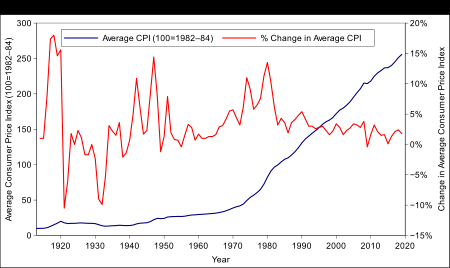

# Fake-data simulation and regression
Simulate 100 data points from the linear model, y = a + bx + error, with a = 5, b = 7, the values of x being samples at random from a uniform distribution on the range [0,50], and errors that are normally distributed with mean 0 and standard deviation 3.

In [92]:
a <- 5
b <- 7
N <- 100

x <- 50*runif(N)
error <- rnorm(N, sd=3) 
y <- a + b * x + error

In [93]:
fake_data <- tibble(x,y)
head(fake_data)

x,y
<dbl>,<dbl>
20.303685,144.34689
28.165551,201.15868
37.674232,269.72578
37.147738,265.11126
6.998855,53.48447
23.125350,164.59637


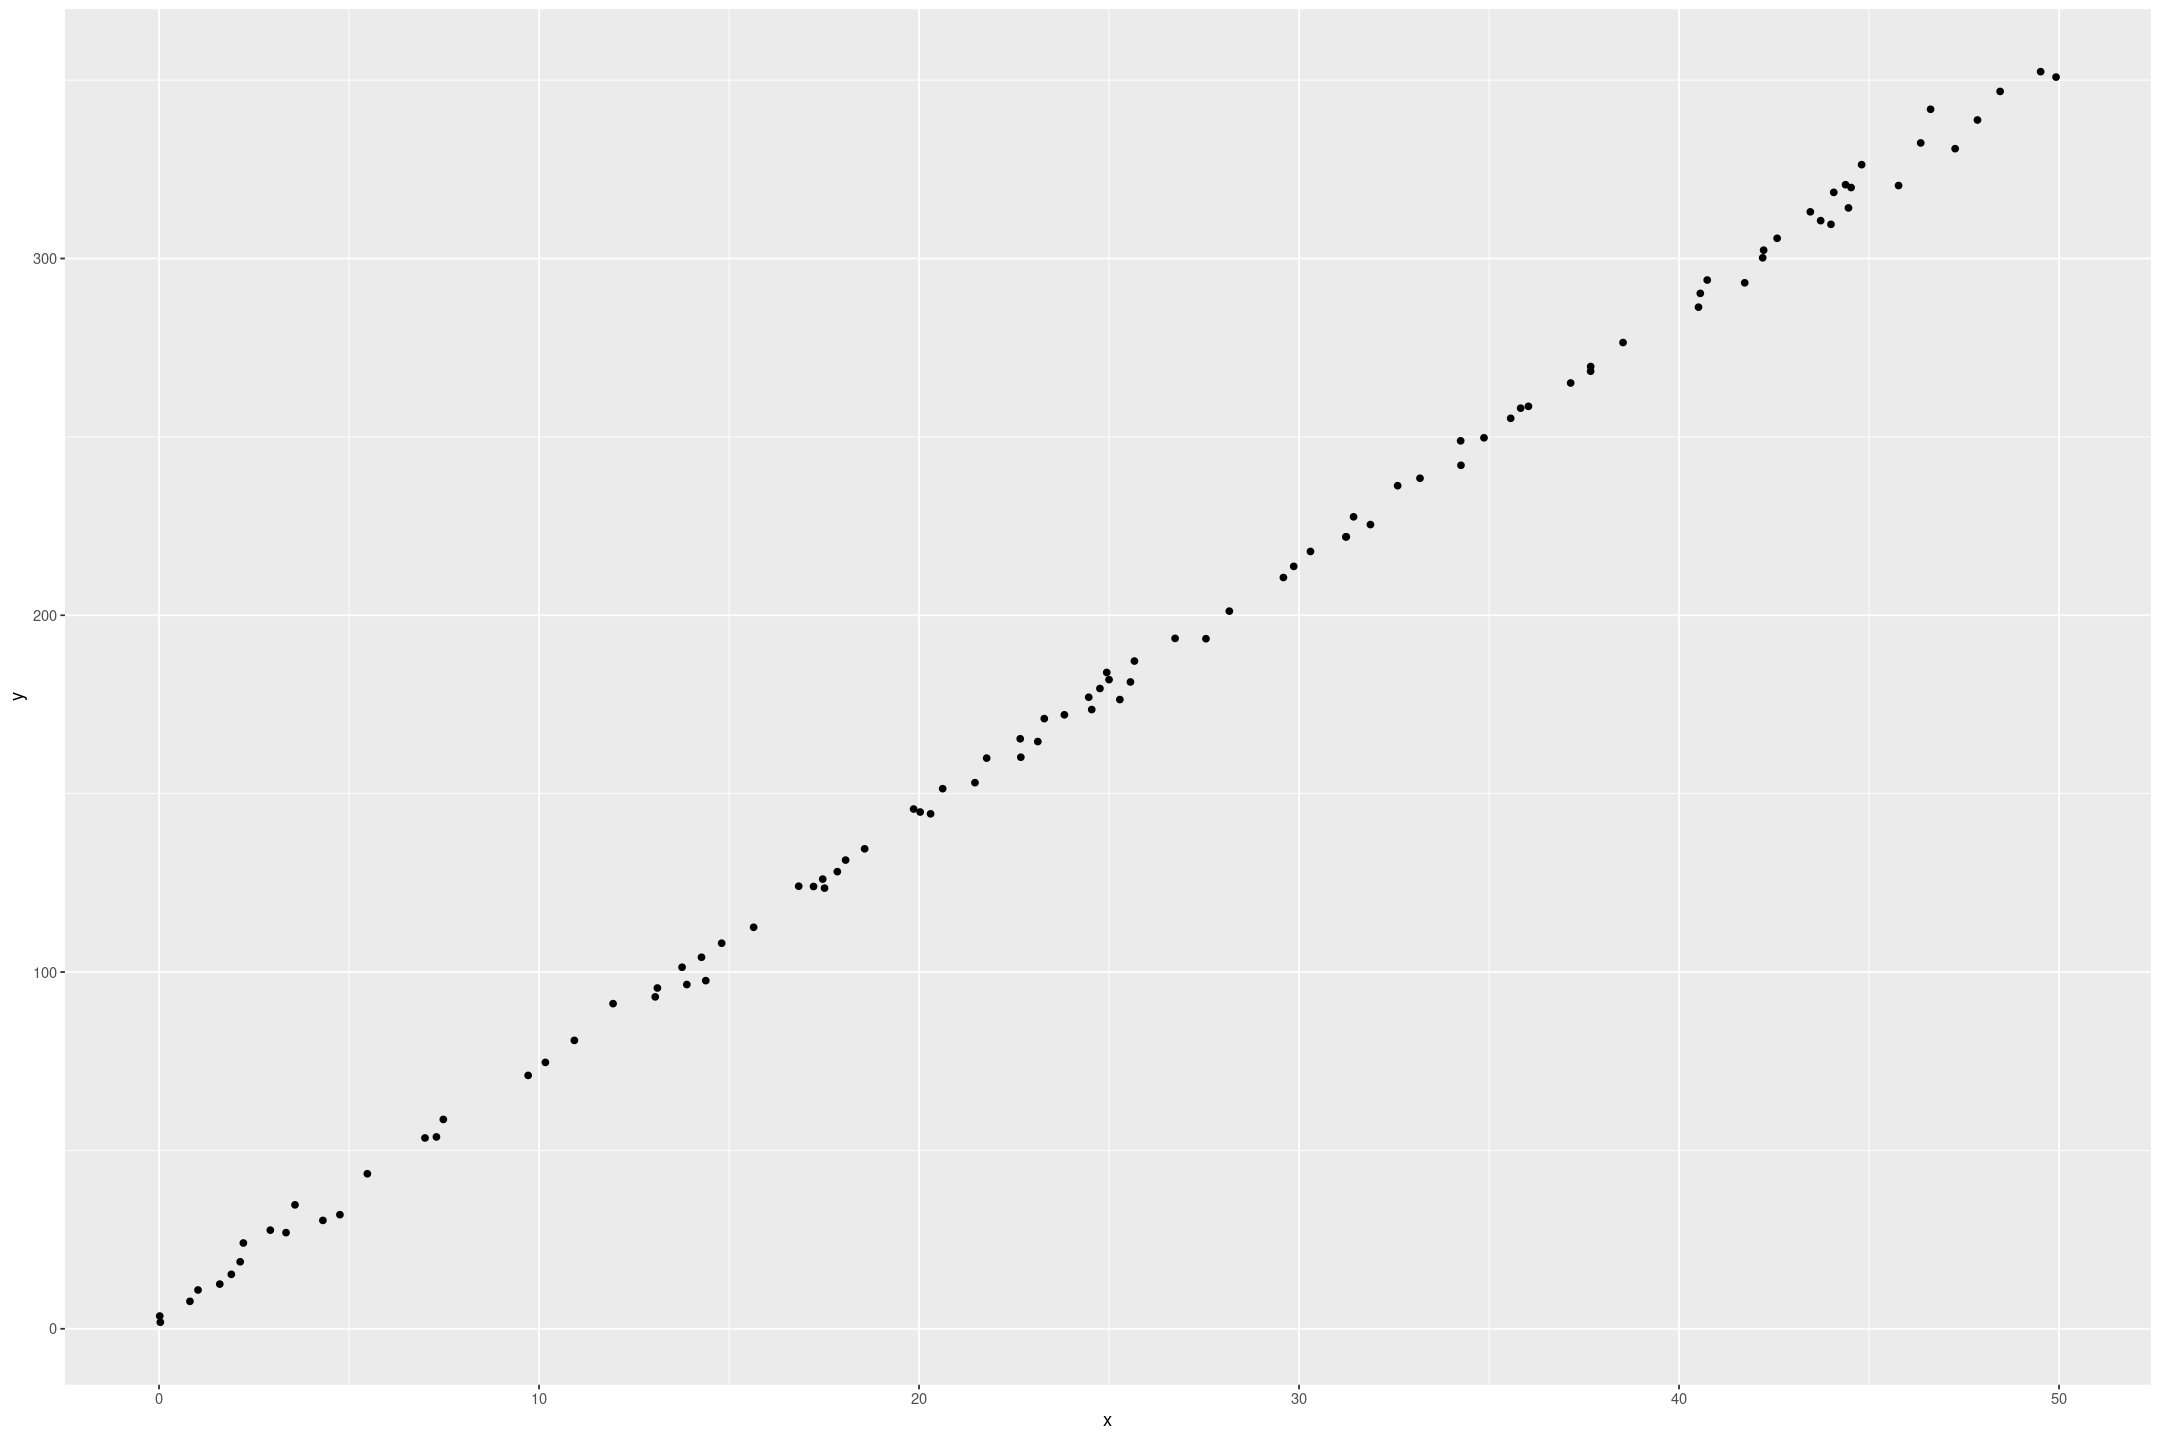

In [94]:
fake_data %>% gf_point(y ~ x)

In [95]:
fake_model <- stan_glm(y ~ x, data=fake_data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.065829 seconds (Warm-up)
Chain 1:                0.079783 seconds (Sampling)
Chain 1:              

Estimates are close to model, especially for slope and standard deviation

In [96]:
print(fake_model)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 3.2    0.6   
x           7.1    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.0    0.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [97]:
coef(fake_model)

(Intercept)           x 
   3.154003    7.064248

In [98]:
label_x <- 25
label_y <- coef(fake_model)[1] + label_x * coef(fake_model)[2]
label_text <- glue("y = {round(coef(fake_model)[1], 1)} + {format(round(coef(fake_model)[2], 1), nsmall=1)} x")

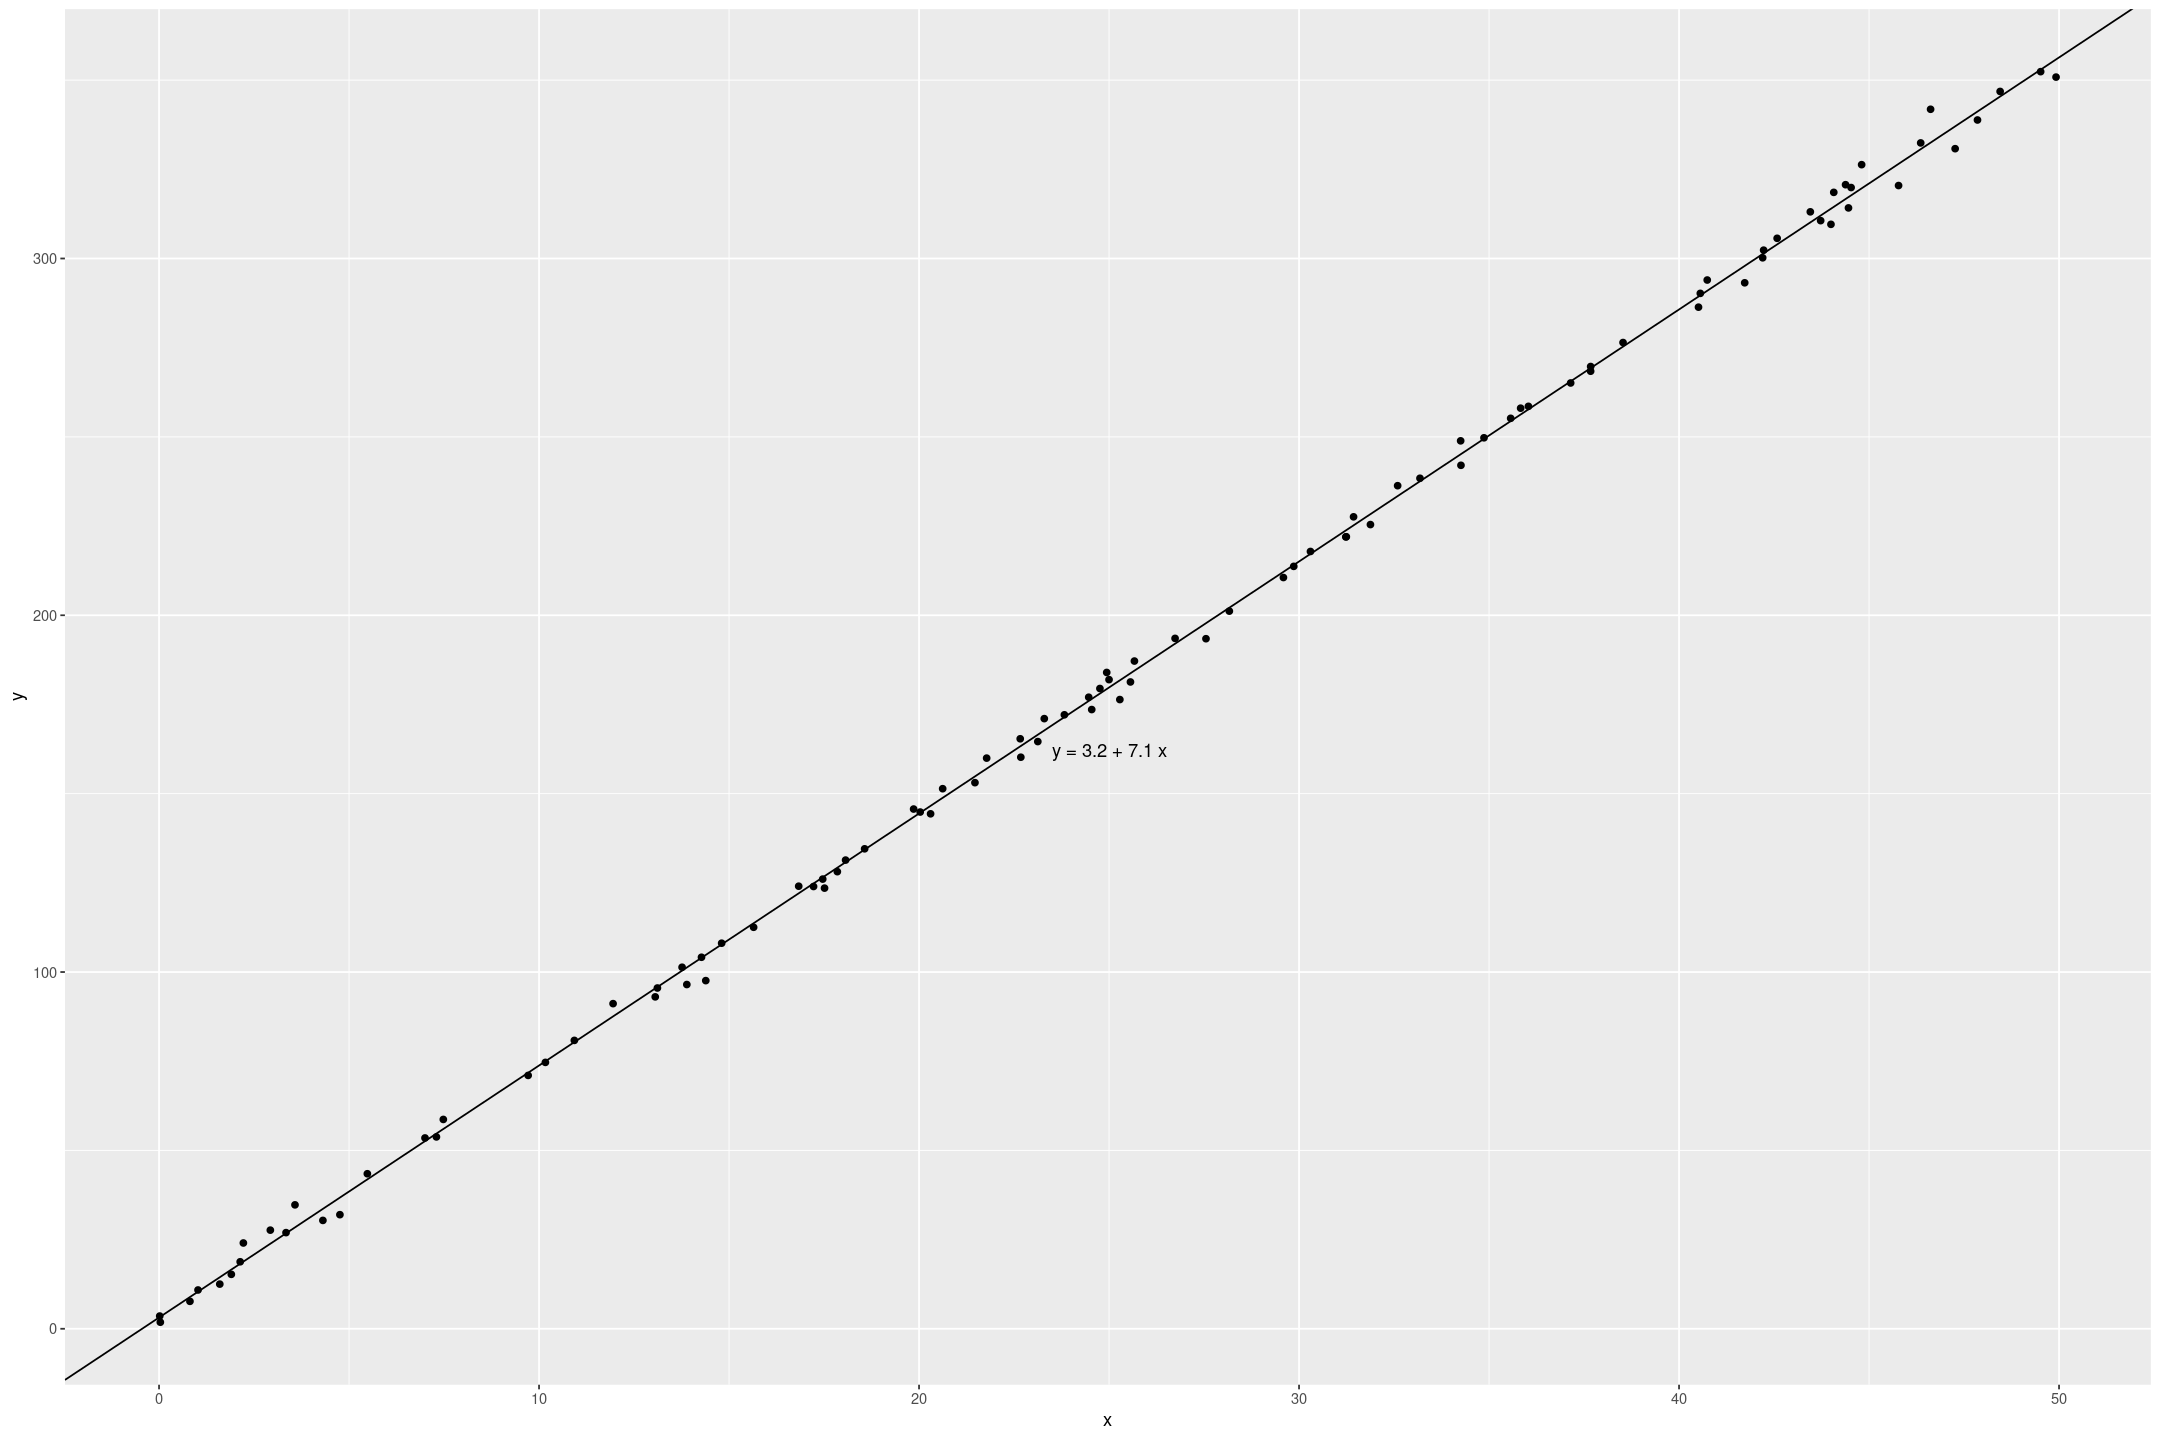

In [99]:
fake_data %>% gf_point(y ~ x) + geom_abline(intercept=coef(fake_model)[1], slope=coef(fake_model)[2]) + 
 geom_text(data=data.frame(x=label_x,y=label_y), aes(x, y), label=label_text, vjust=5)

# Fake-data simulation and fitting the wrong model
Simulate 100 data points from the linear model, y = a + bx + cx^2 + error, wtih the values of x being samples at random from a uniform distribution on the range [0,50], and errors that are normally distributed with mean 0 and standard deviation 3, and a, b, c chosen so that a scatterplot of the data shows a clear non-linear curve.

In [100]:
a <- 5
b <- 7
c <- 3
N <- 100

x <- 50*runif(N)
error <- rnorm(N, sd=3) 
y <- a + b * x + c*x^2 + error

In [101]:
fake_data <- tibble(x,y)
head(fake_data)

x,y
<dbl>,<dbl>
16.224092,912.57559
11.153698,456.25875
26.385785,2277.51214
17.866661,1086.88582
3.676538,69.94202
17.310584,1022.09612


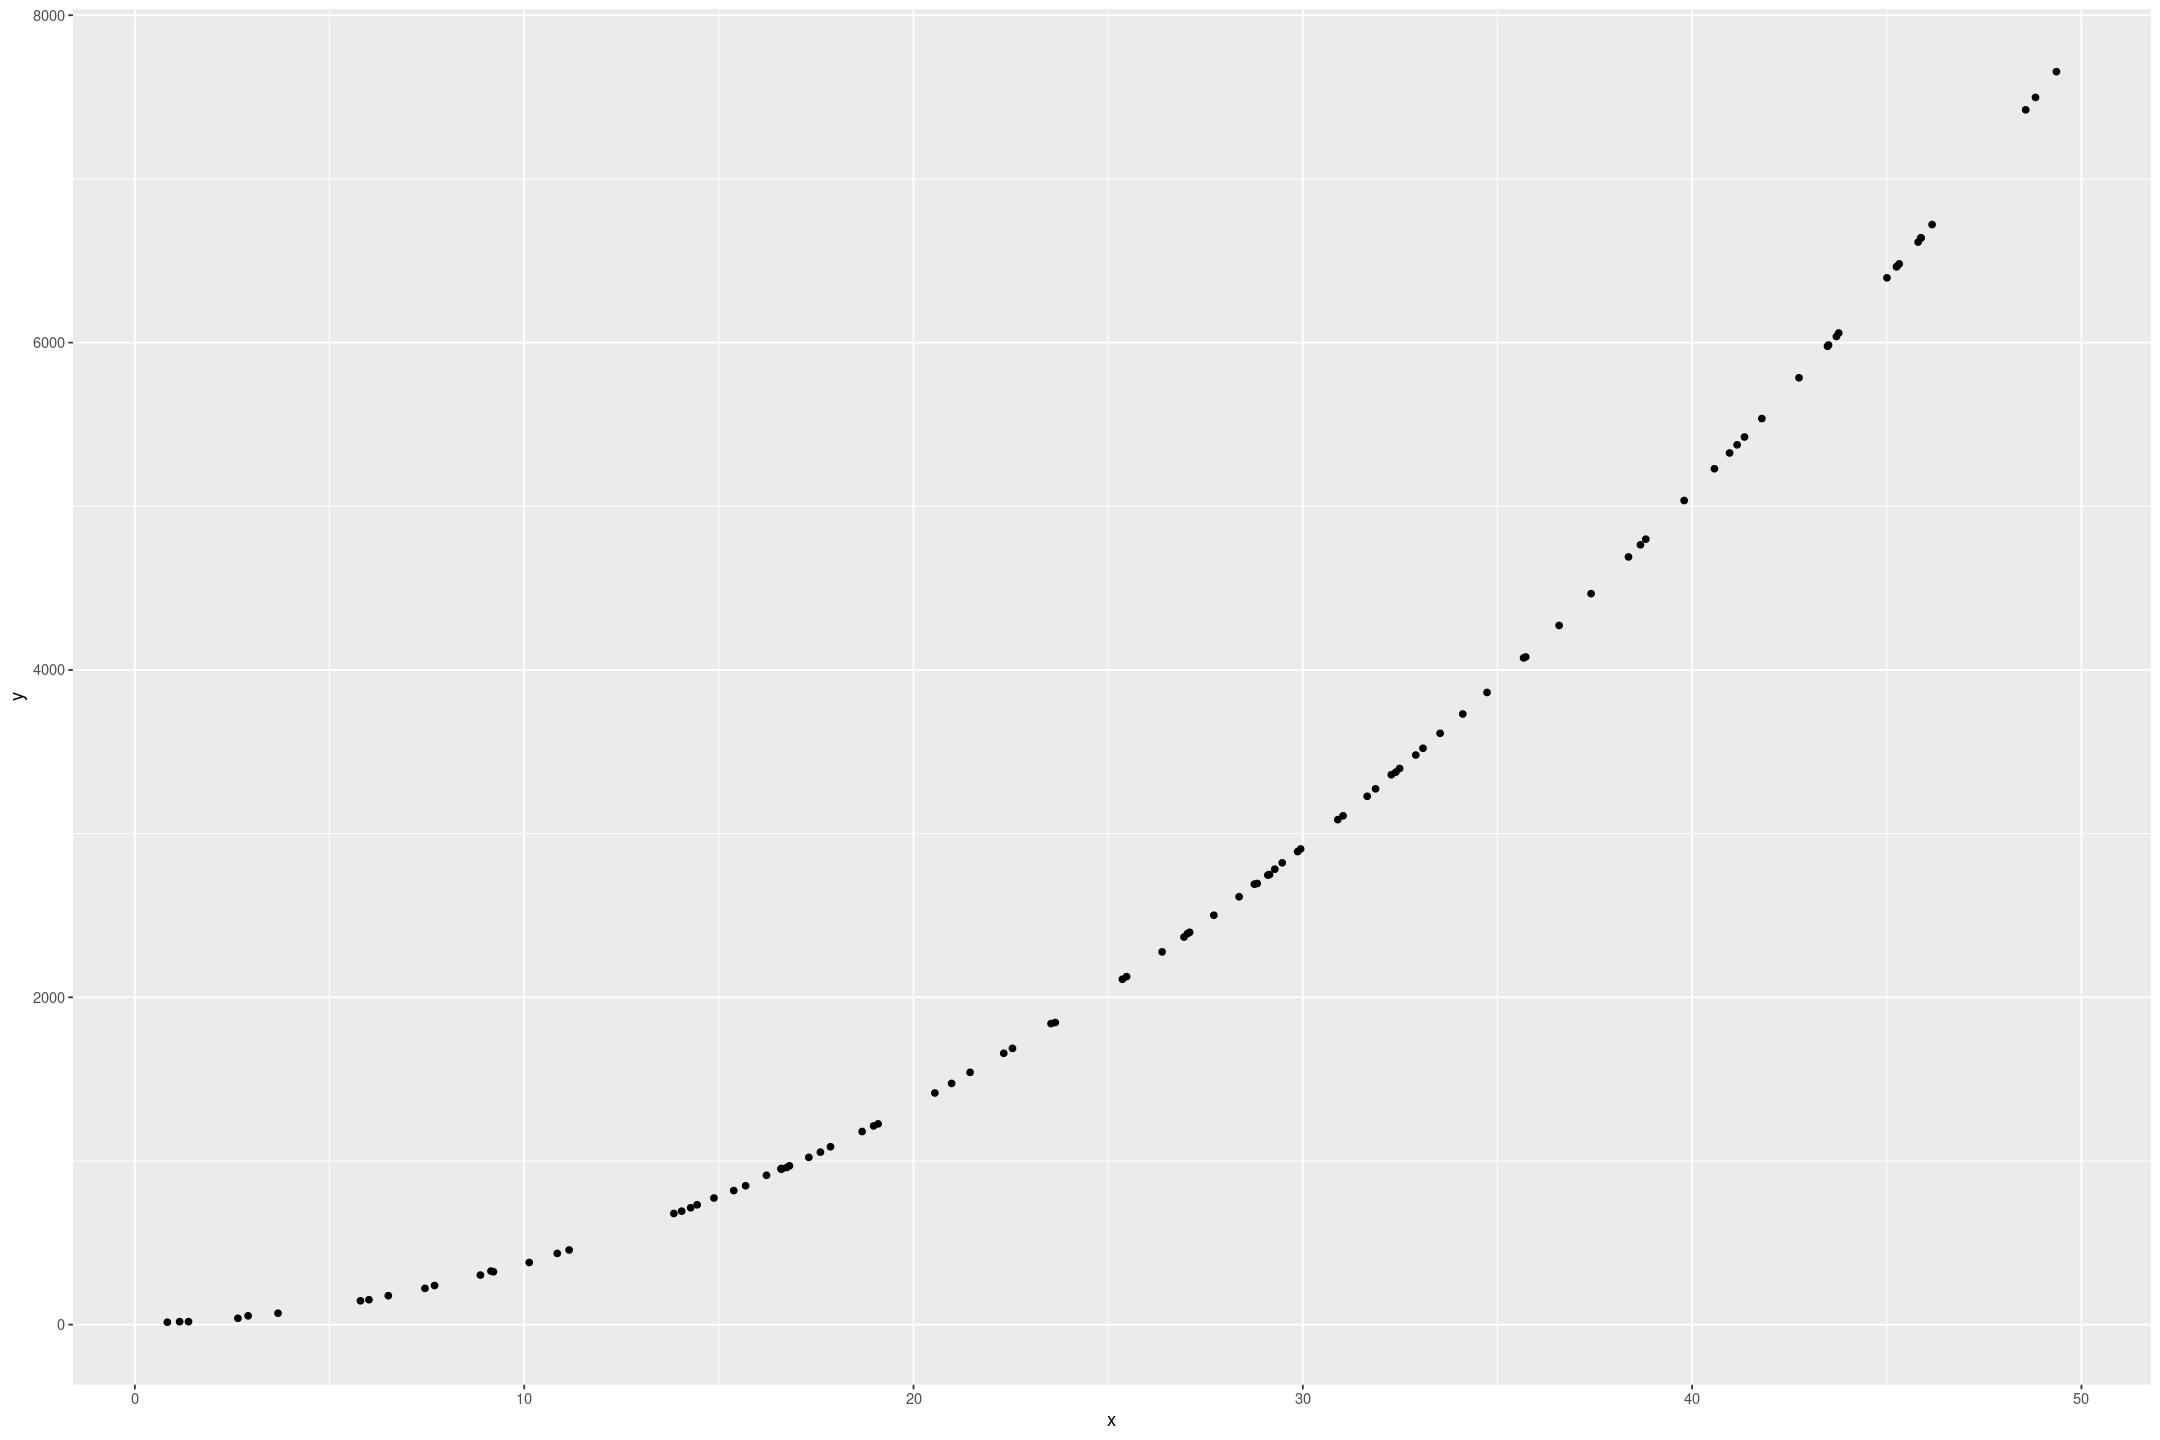

In [102]:
fake_data %>% gf_point(y ~ x)

a) Fitting a regression line `stan_glm(y ~ x)` to the data

In [103]:
model <- stan_glm(y ~ x, data=fake_data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.187153 seconds (Warm-up)
Chain 1:                0.038572 seconds (Sampling)
Chain 1:              

Notice the parameters are large, especially the error!

In [104]:
print(model)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median  MAD_SD 
(Intercept) -1428.4   116.6
x             160.7     4.0

Auxiliary parameter(s):
      Median MAD_SD
sigma 530.1   39.7 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


We can still find a line of best fit (minimising the sum of squared error), but it's far from the actual model.

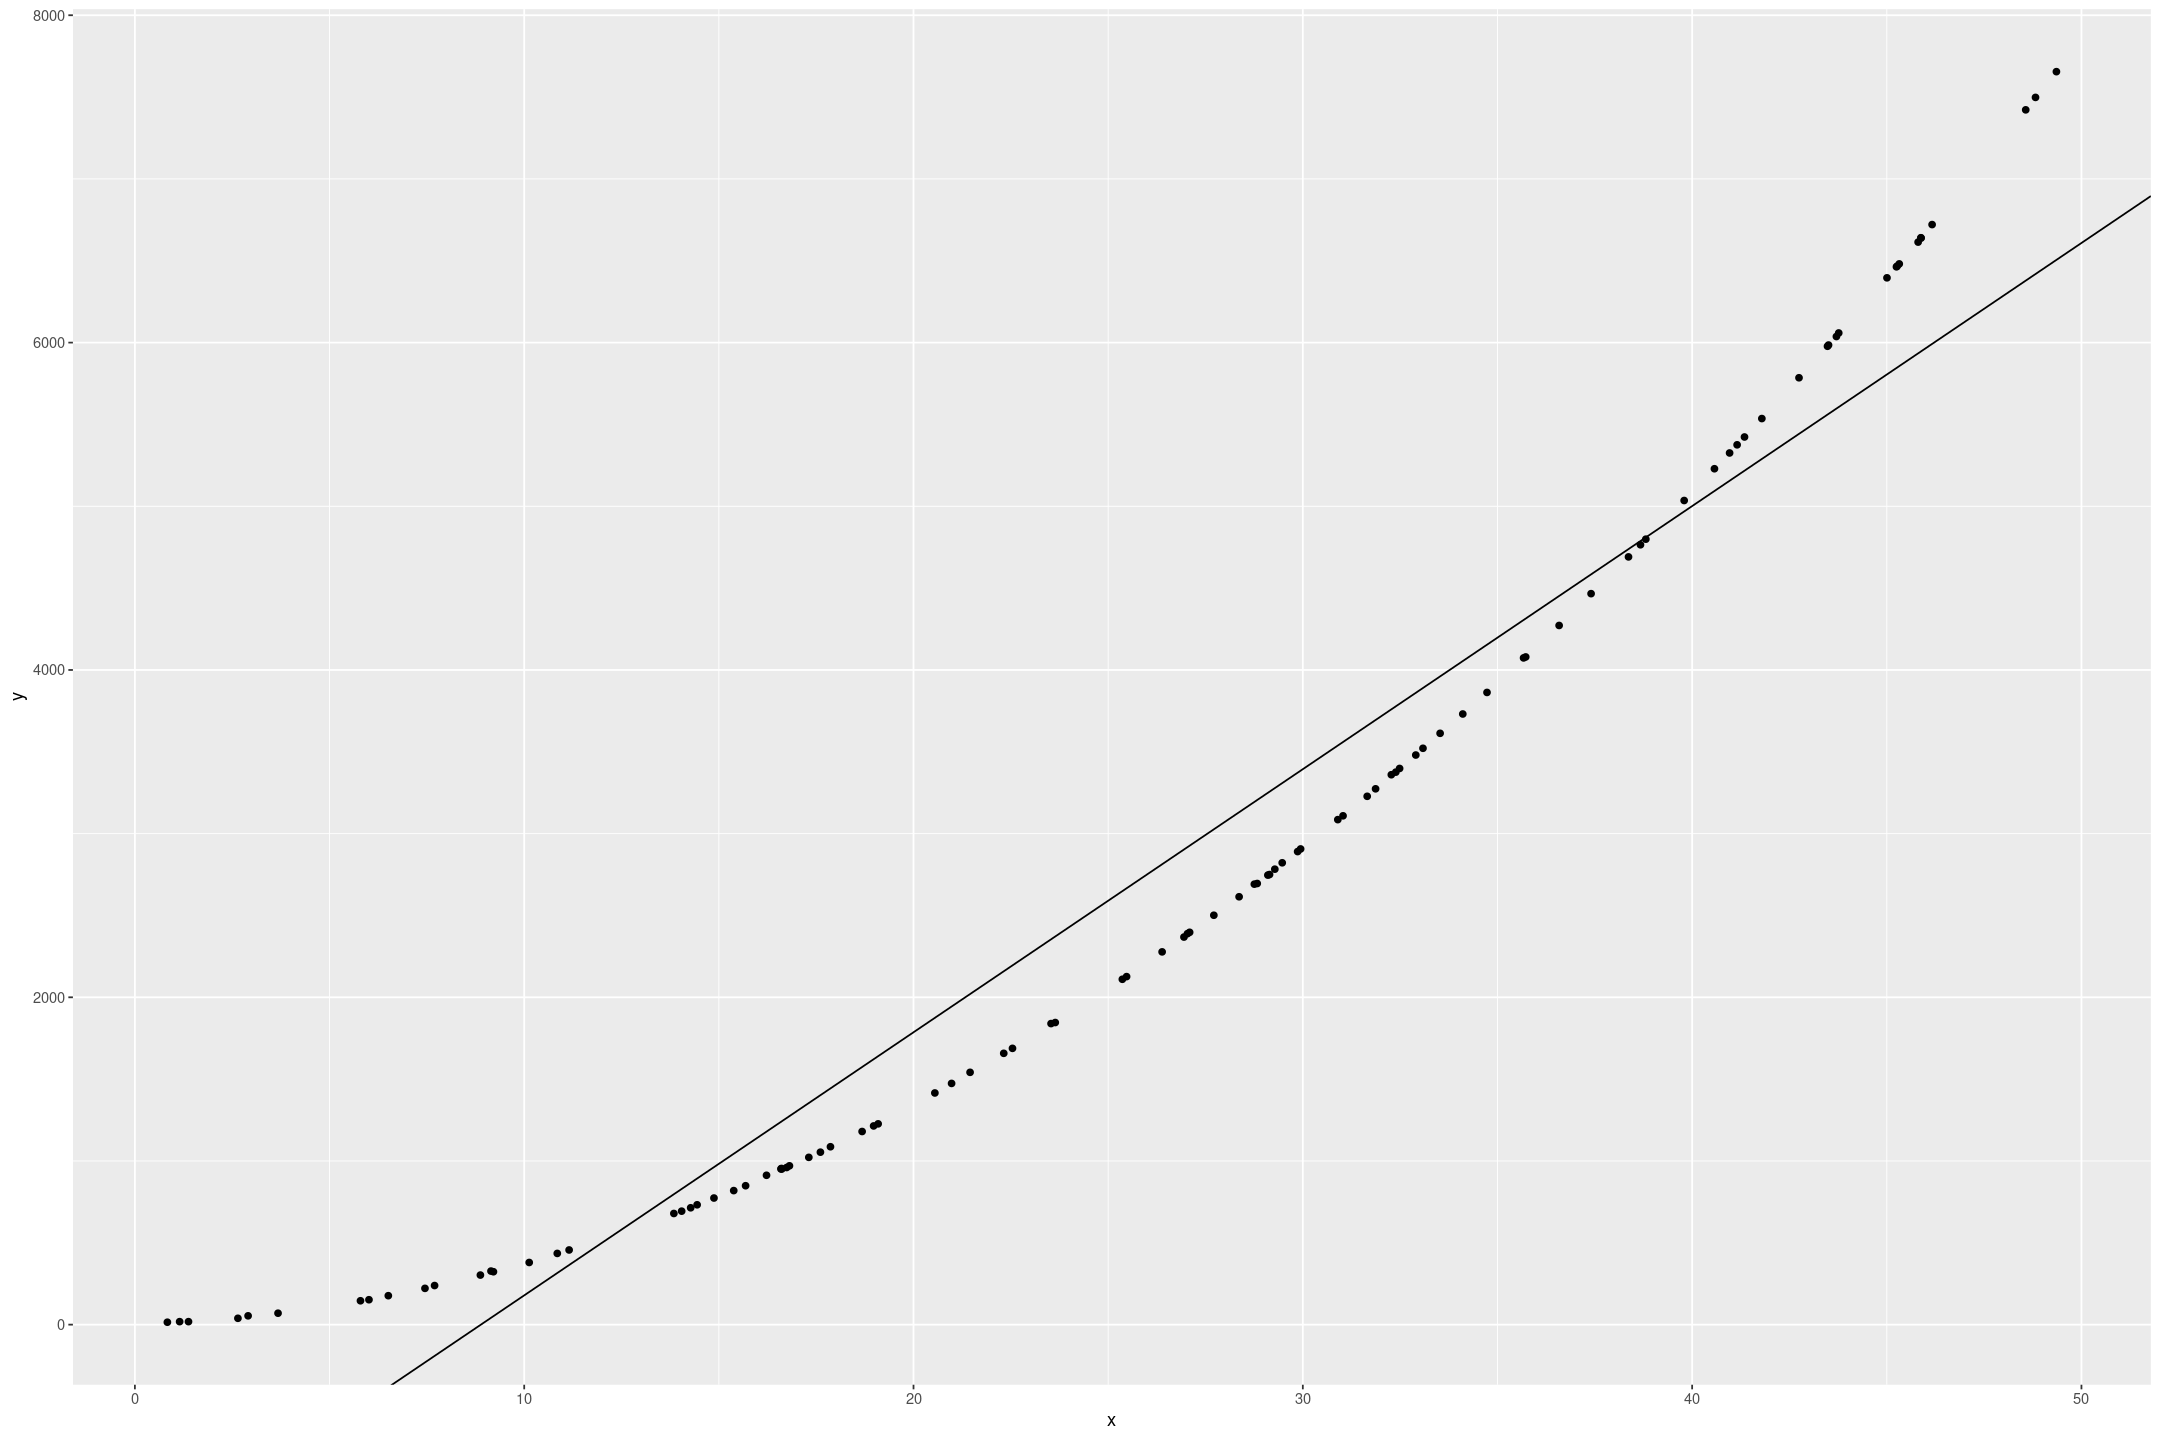

In [105]:
fake_data %>% gf_point(y ~ x) + geom_abline(intercept=coef(model)[1], slope = coef(model)[2])

We could extend the model to fit a quadratic by adding a predictor

In [106]:
fake_data <- fake_data %>% mutate(x2 = x*x)
head(fake_data)

x,y,x2
<dbl>,<dbl>,<dbl>
16.224092,912.57559,263.22116
11.153698,456.25875,124.40498
26.385785,2277.51214,696.20964
17.866661,1086.88582,319.21757
3.676538,69.94202,13.51693
17.310584,1022.09612,299.65632


In [107]:
quadratic_model <- stan_glm(y ~ x + x2, data=fake_data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.737882 seconds (Warm-up)
Chain 1:                0.648407 seconds (Sampling)
Chain 1:              

Fits the model very well

In [108]:
print(quadratic_model)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x + x2
 observations: 100
 predictors:   3
------
            Median MAD_SD
(Intercept) 4.6    1.1   
x           7.0    0.1   
x2          3.0    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.0    0.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [109]:
coef(quadratic_model)

(Intercept)           x          x2 
   4.643323    7.018400    2.999305

In [110]:
fitted_curve <- tibble(x=seq(0, 50, by=0.1)) %>% mutate(y = coef(quadratic_model)[1] + coef(quadratic_model)[2] * x + coef(quadratic_model)[3] * x^2)

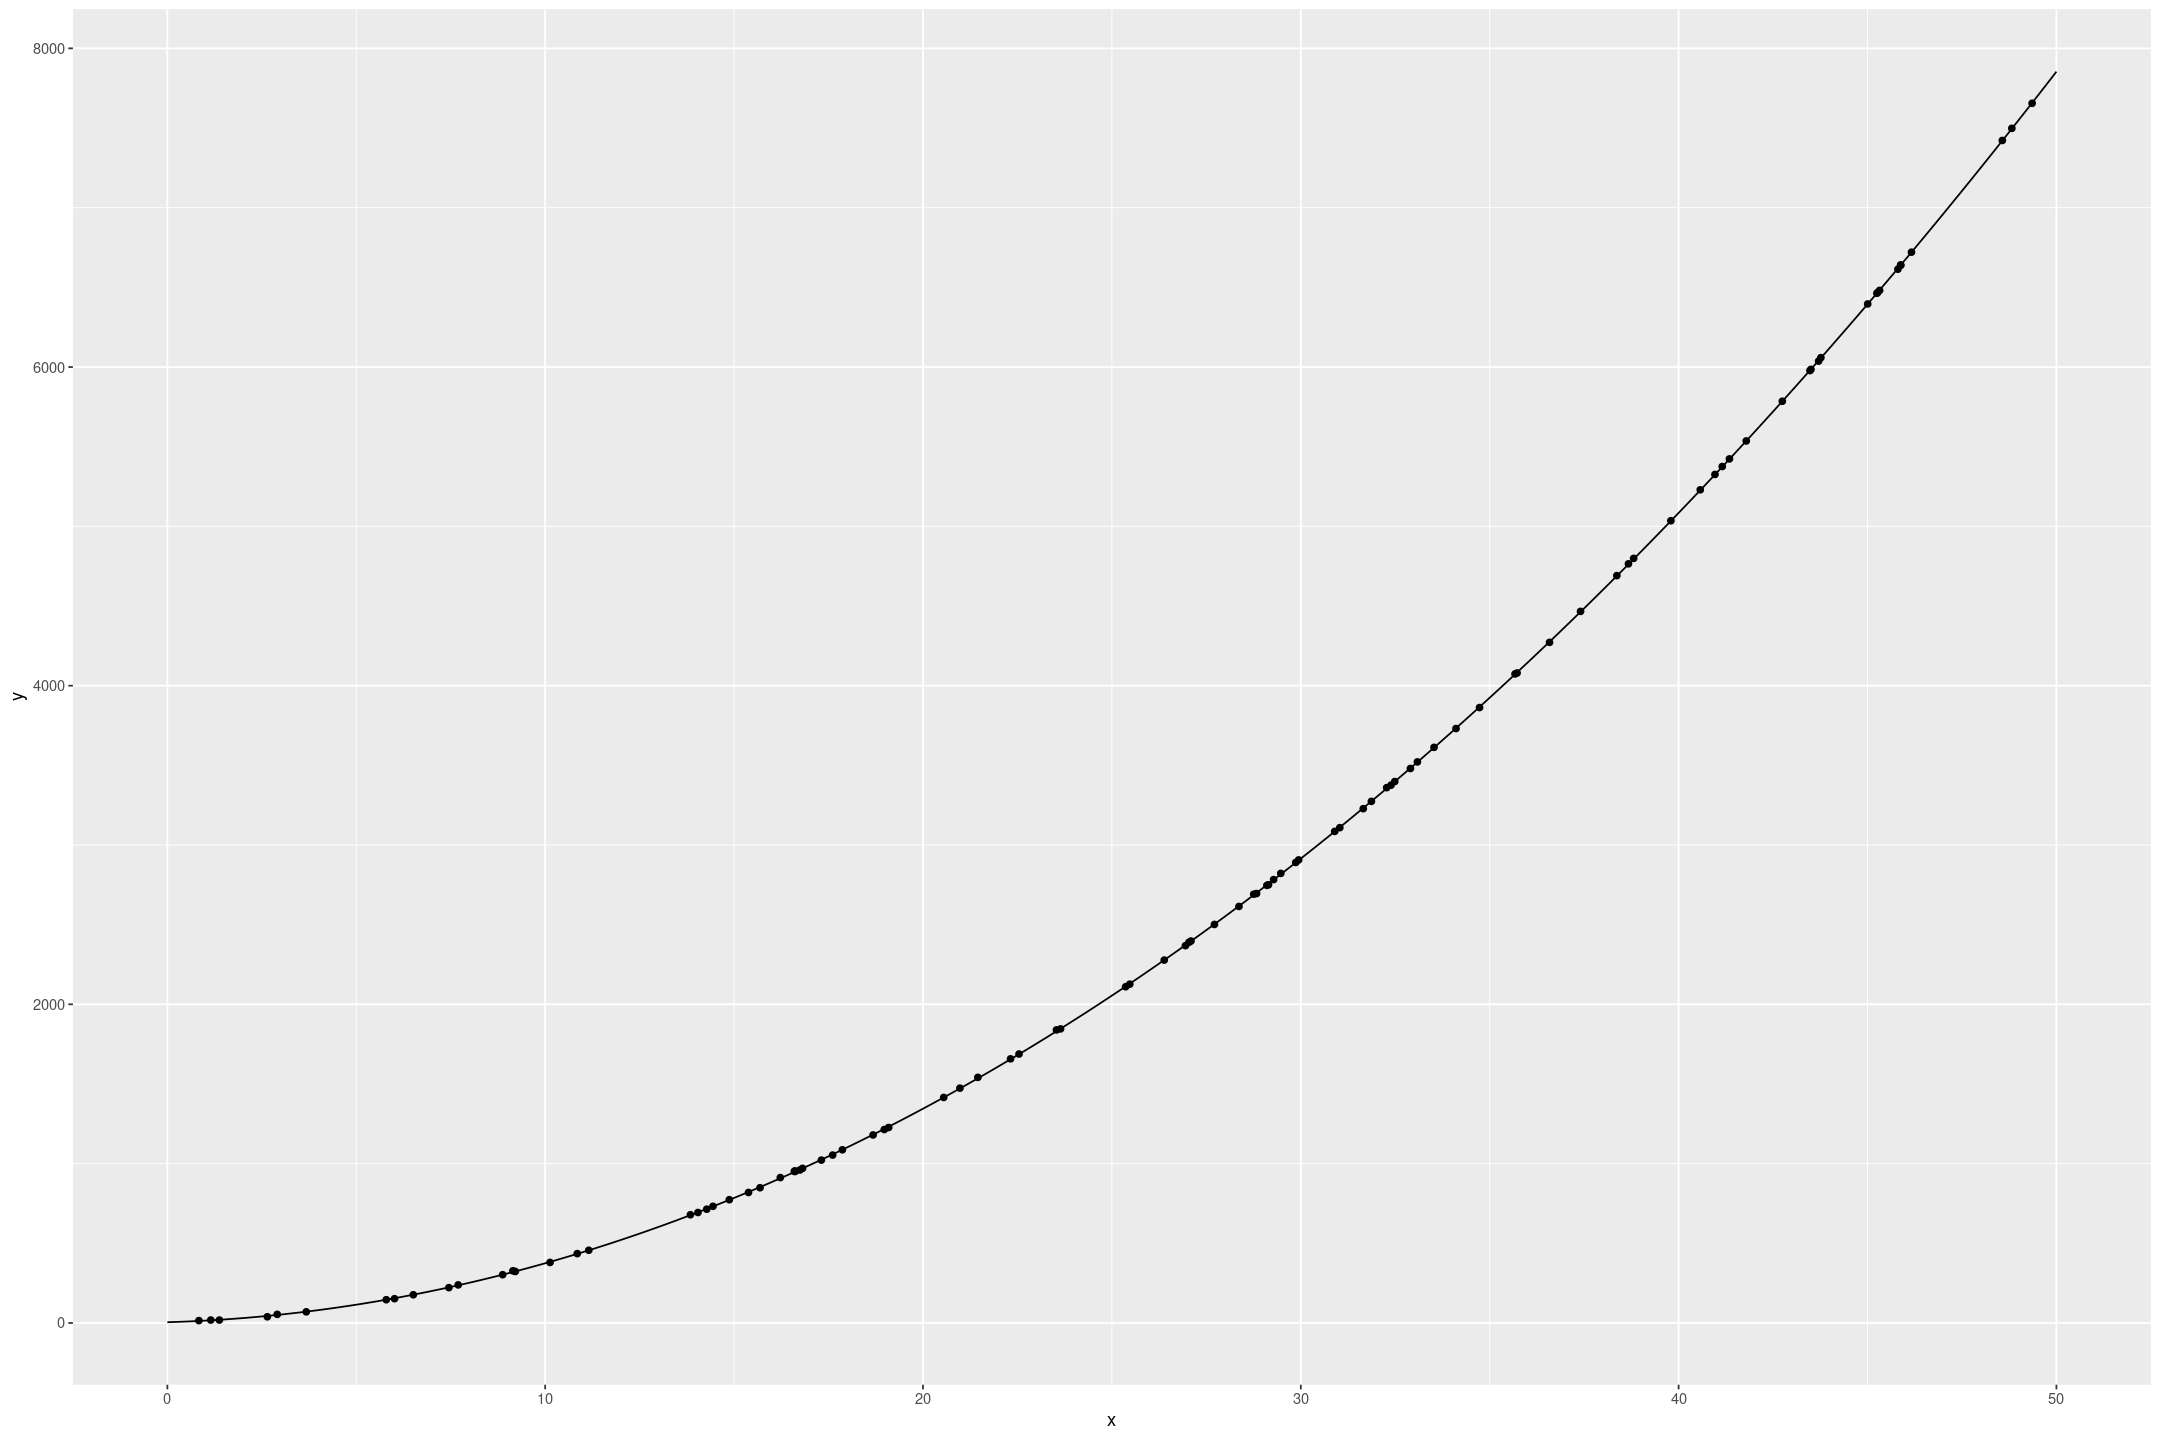

In [111]:
fake_data %>% gf_point(y ~ x) %>% gf_line(y ~ x, data=fitted_curve)

# Prediction
Following the template of Section 7.1, find data in which one variable can be used to predict the other, then fit a linear model and plot it along with the data, then display the model and explain in words as on page 95. Use the model to obtain a probabalistic prediction for new data, and evaluate that prediction, as in the last part of Section 7.1.

## Getting Data

I've heard that religiosity is strongly correlated with fertility. Let's check this.

For religiosity Wikipedia has a copy of [Gallup Data](https://news.gallup.com/poll/142727/religiosity-highest-world-poorest-nations.aspx) from 2009 about "Is religion important in your daily life?".
It's based on a sample of 1000 people per country, using telephone and in person surveys.

In [112]:
importance_religion_html <- xml2::read_html("https://en.wikipedia.org/wiki/Importance_of_religion_by_country")

In [113]:
importance_religion_raw <- importance_religion_html %>%
rvest::html_nodes("table") %>% 
.[[2]] %>%
rvest::html_table()

importance_religion_raw

Rank,Country,"Yes, important[1]","No, unimportant[1]"
<int>,<chr>,<chr>,<chr>
1,Estonia,14%,86%
2,Sweden,15%,85%
3,Denmark,19%,81%
4,Czech Republic[a],21%,75%
5,Norway[a],22%,78%
6,Japan,24%,75%
7,Hong Kong,24%,74%
8,United Kingdom,27%,73%
9,Finland[a],28%,70%


The columns with an `[a]` in the name are from a 2008 survey; which is probably close enough.

Let's normalise this by:

* Renaming the columns to something nice
* Separating out the `[a]` annotaion as a survey year identifier
* Removing the `[a]` from country names
* Extracting the country code (which is unambiguous as opposed to country name, which can be different e.g. Russia vs Russian Federation)
* Converting percentage strings to decimal

In [114]:
convert_percent <- function(x)
    as.numeric(str_remove(x, "%$"))/100

In [115]:
importance_religion <- 
importance_religion_raw %>% 
rename_with(~str_remove(tolower(.), ",.*")) %>%
mutate(year=if_else(str_ends(country, '[a]'), 2008L, 2009L),
       country = as.factor(str_remove(country, "\\[a\\]$")),
       iso2c = countrycode::countrycode(country, origin='country.name', destination='iso2c'),
       yes = convert_percent(yes),
       no = convert_percent(no))

importance_religion

rank,country,yes,no,year,iso2c
<int>,<fct>,<dbl>,<dbl>,<int>,<chr>
1,Estonia,0.14,0.86,2008,EE
2,Sweden,0.15,0.85,2009,SE
3,Denmark,0.19,0.81,2009,DK
4,Czech Republic,0.21,0.75,2009,CZ
5,Norway,0.22,0.78,2009,NO
6,Japan,0.24,0.75,2009,JP
7,Hong Kong,0.24,0.74,2009,HK
8,United Kingdom,0.27,0.73,2009,GB
9,Finland,0.28,0.70,2009,FI


[Fertility rate, total (births per woman)](https://data.worldbank.org/indicator/SP.DYN.TFRT.IN) data from World Bank

In [116]:
fertility <- WDI::WDI(country=importance_religion$iso2c, indicator="SP.DYN.TFRT.IN", start=2008, end=2009) %>%
rename(fertility = "SP.DYN.TFRT.IN")

In [117]:
fertility %>% t()

iso2c,AF,AF,AO,AO,AL,AL,AE,AE,AR,AR,AM,AM,AU,AU,AT,AT,AZ,AZ,BI,BI,BE,BE,BJ,BJ,BF,BF,BD,BD,BG,BG,BH,BH,BA,BA,BY,BY,BZ,BZ,BO,BO,BR,BR,BW,BW,CF,CF,CA,CA,CH,CH,CL,CL,CI,CI,CM,CM,CD,CD,CG,CG,CO,CO,KM,KM,CR,CR,CU,CU,CY,CY,CZ,CZ,DE,DE,DJ,⋯,PL,PT,PT,PY,PY,PS,PS,QA,QA,RO,RO,RU,RU,RW,RW,SA,SA,SD,SD,SN,SN,SG,SG,SO,SO,RS,RS,SK,SK,SI,SI,SE,SE,SY,SY,TD,TD,TG,TG,TH,TH,TJ,TJ,TM,TM,TT,TT,TN,TN,TR,TR,TZ,TZ,UG,UG,UA,UA,UY,UY,US,US,UZ,UZ,VE,VE,VN,VN,YE,YE,ZA,ZA,ZM,ZM,ZW,ZW
country,Afghanistan,Afghanistan,Angola,Angola,Albania,Albania,United Arab Emirates,United Arab Emirates,Argentina,Argentina,Armenia,Armenia,Australia,Australia,Austria,Austria,Azerbaijan,Azerbaijan,Burundi,Burundi,Belgium,Belgium,Benin,Benin,Burkina Faso,Burkina Faso,Bangladesh,Bangladesh,Bulgaria,Bulgaria,Bahrain,Bahrain,Bosnia and Herzegovina,Bosnia and Herzegovina,Belarus,Belarus,Belize,Belize,Bolivia,Bolivia,Brazil,Brazil,Botswana,Botswana,Central African Republic,Central African Republic,Canada,Canada,Switzerland,Switzerland,Chile,Chile,Cote d'Ivoire,Cote d'Ivoire,Cameroon,Cameroon,"Congo, Dem. Rep.","Congo, Dem. Rep.","Congo, Rep.","Congo, Rep.",Colombia,Colombia,Comoros,Comoros,Costa Rica,Costa Rica,Cuba,Cuba,Cyprus,Cyprus,Czech Republic,Czech Republic,Germany,Germany,Djibouti,⋯,Poland,Portugal,Portugal,Paraguay,Paraguay,West Bank and Gaza,West Bank and Gaza,Qatar,Qatar,Romania,Romania,Russian Federation,Russian Federation,Rwanda,Rwanda,Saudi Arabia,Saudi Arabia,Sudan,Sudan,Senegal,Senegal,Singapore,Singapore,Somalia,Somalia,Serbia,Serbia,Slovak Republic,Slovak Republic,Slovenia,Slovenia,Sweden,Sweden,Syrian Arab Republic,Syrian Arab Republic,Chad,Chad,Togo,Togo,Thailand,Thailand,Tajikistan,Tajikistan,Turkmenistan,Turkmenistan,Trinidad and Tobago,Trinidad and Tobago,Tunisia,Tunisia,Turkey,Turkey,Tanzania,Tanzania,Uganda,Uganda,Ukraine,Ukraine,Uruguay,Uruguay,United States,United States,Uzbekistan,Uzbekistan,"Venezuela, RB","Venezuela, RB",Vietnam,Vietnam,"Yemen, Rep.","Yemen, Rep.",South Africa,South Africa,Zambia,Zambia,Zimbabwe,Zimbabwe
fertility,6.1800,6.3730,6.2600,6.3200,1.6520,1.6540,1.8770,1.9390,2.3550,2.3660,1.7190,1.7120,1.9710,1.9840,1.3900,1.4200,1.8200,1.9000,6.2670,6.3520,1.8400,1.8500,5.4160,5.4690,5.9530,6.0360,2.3820,2.4490,1.6600,1.5600,2.1970,2.2410,1.3110,1.3030,1.5090,1.4880,2.7490,2.8160,3.2870,3.3640,1.8180,1.8470,3.0260,3.0340,5.2540,5.2890,1.6680,1.6808,1.5000,1.4800,1.8920,1.8950,5.1520,5.2210,5.1670,5.2190,6.5870,6.6210,4.7840,4.7980,2.0330,2.0810,4.8130,4.8700,1.9030,1.9230,1.6240,1.6020,1.4430,1.4610,1.5100,1.5100,1.3600,1.3800,3.3970,⋯,1.3900,1.3400,1.3900,2.7870,2.8460,4.5040,4.5670,2.1300,2.2110,1.6600,1.6000,1.5420,1.5020,4.6410,4.7670,3.0660,3.1580,4.9260,4.9770,5.0810,5.0940,1.2200,1.2800,6.9610,7.0550,1.4400,1.4000,1.4400,1.3400,1.5300,1.5300,1.9400,1.9100,3.5140,3.6130,6.6990,6.8030,4.9360,5.0010,1.5450,1.5490,3.5960,3.5940,2.7690,2.7120,1.8040,1.7990,2.0950,2.0540,2.1680,2.1890,5.4890,5.5420,6.2270,6.3330,1.4730,1.4580,2.0180,2.0300,2.0020,2.0720,2.5300,2.6370,2.5000,2.5300,1.9280,1.9180,4.8010,4.9400,2.6080,2.6110,5.4960,5.5740,3.9880,3.9310
year,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,⋯,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008


We could try to join on country name but we miss a few

In [118]:
religion_fertility <- 
importance_religion %>% rename(religion=yes) %>% select(-no) %>%
left_join(fertility %>% select(-country), by=c('iso2c', 'year'))

religion_fertility

rank,country,religion,year,iso2c,fertility
<int>,<fct>,<dbl>,<int>,<chr>,<dbl>
1,Estonia,0.14,2008,EE,1.7200
2,Sweden,0.15,2009,SE,1.9400
3,Denmark,0.19,2009,DK,1.8400
4,Czech Republic,0.21,2009,CZ,1.5100
5,Norway,0.22,2009,NO,1.9800
6,Japan,0.24,2009,JP,1.3700
7,Hong Kong,0.24,2009,HK,1.0550
8,United Kingdom,0.27,2009,GB,1.8900
9,Finland,0.28,2009,FI,1.8600


Only missing Taiwan, probably for political reasons.

Let's drop it for now.

In [119]:
religion_fertility %>% filter(is.na(fertility))

rank,country,religion,year,iso2c,fertility
<int>,<fct>,<dbl>,<int>,<chr>,<dbl>
30,Taiwan,0.45,2009,TW,NA


In [120]:
religion_fertility <- religion_fertility %>% filter(!is.na(fertility))

There definitely a positive correlation between importance of religion and fertility, but it looks more than linear.

Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


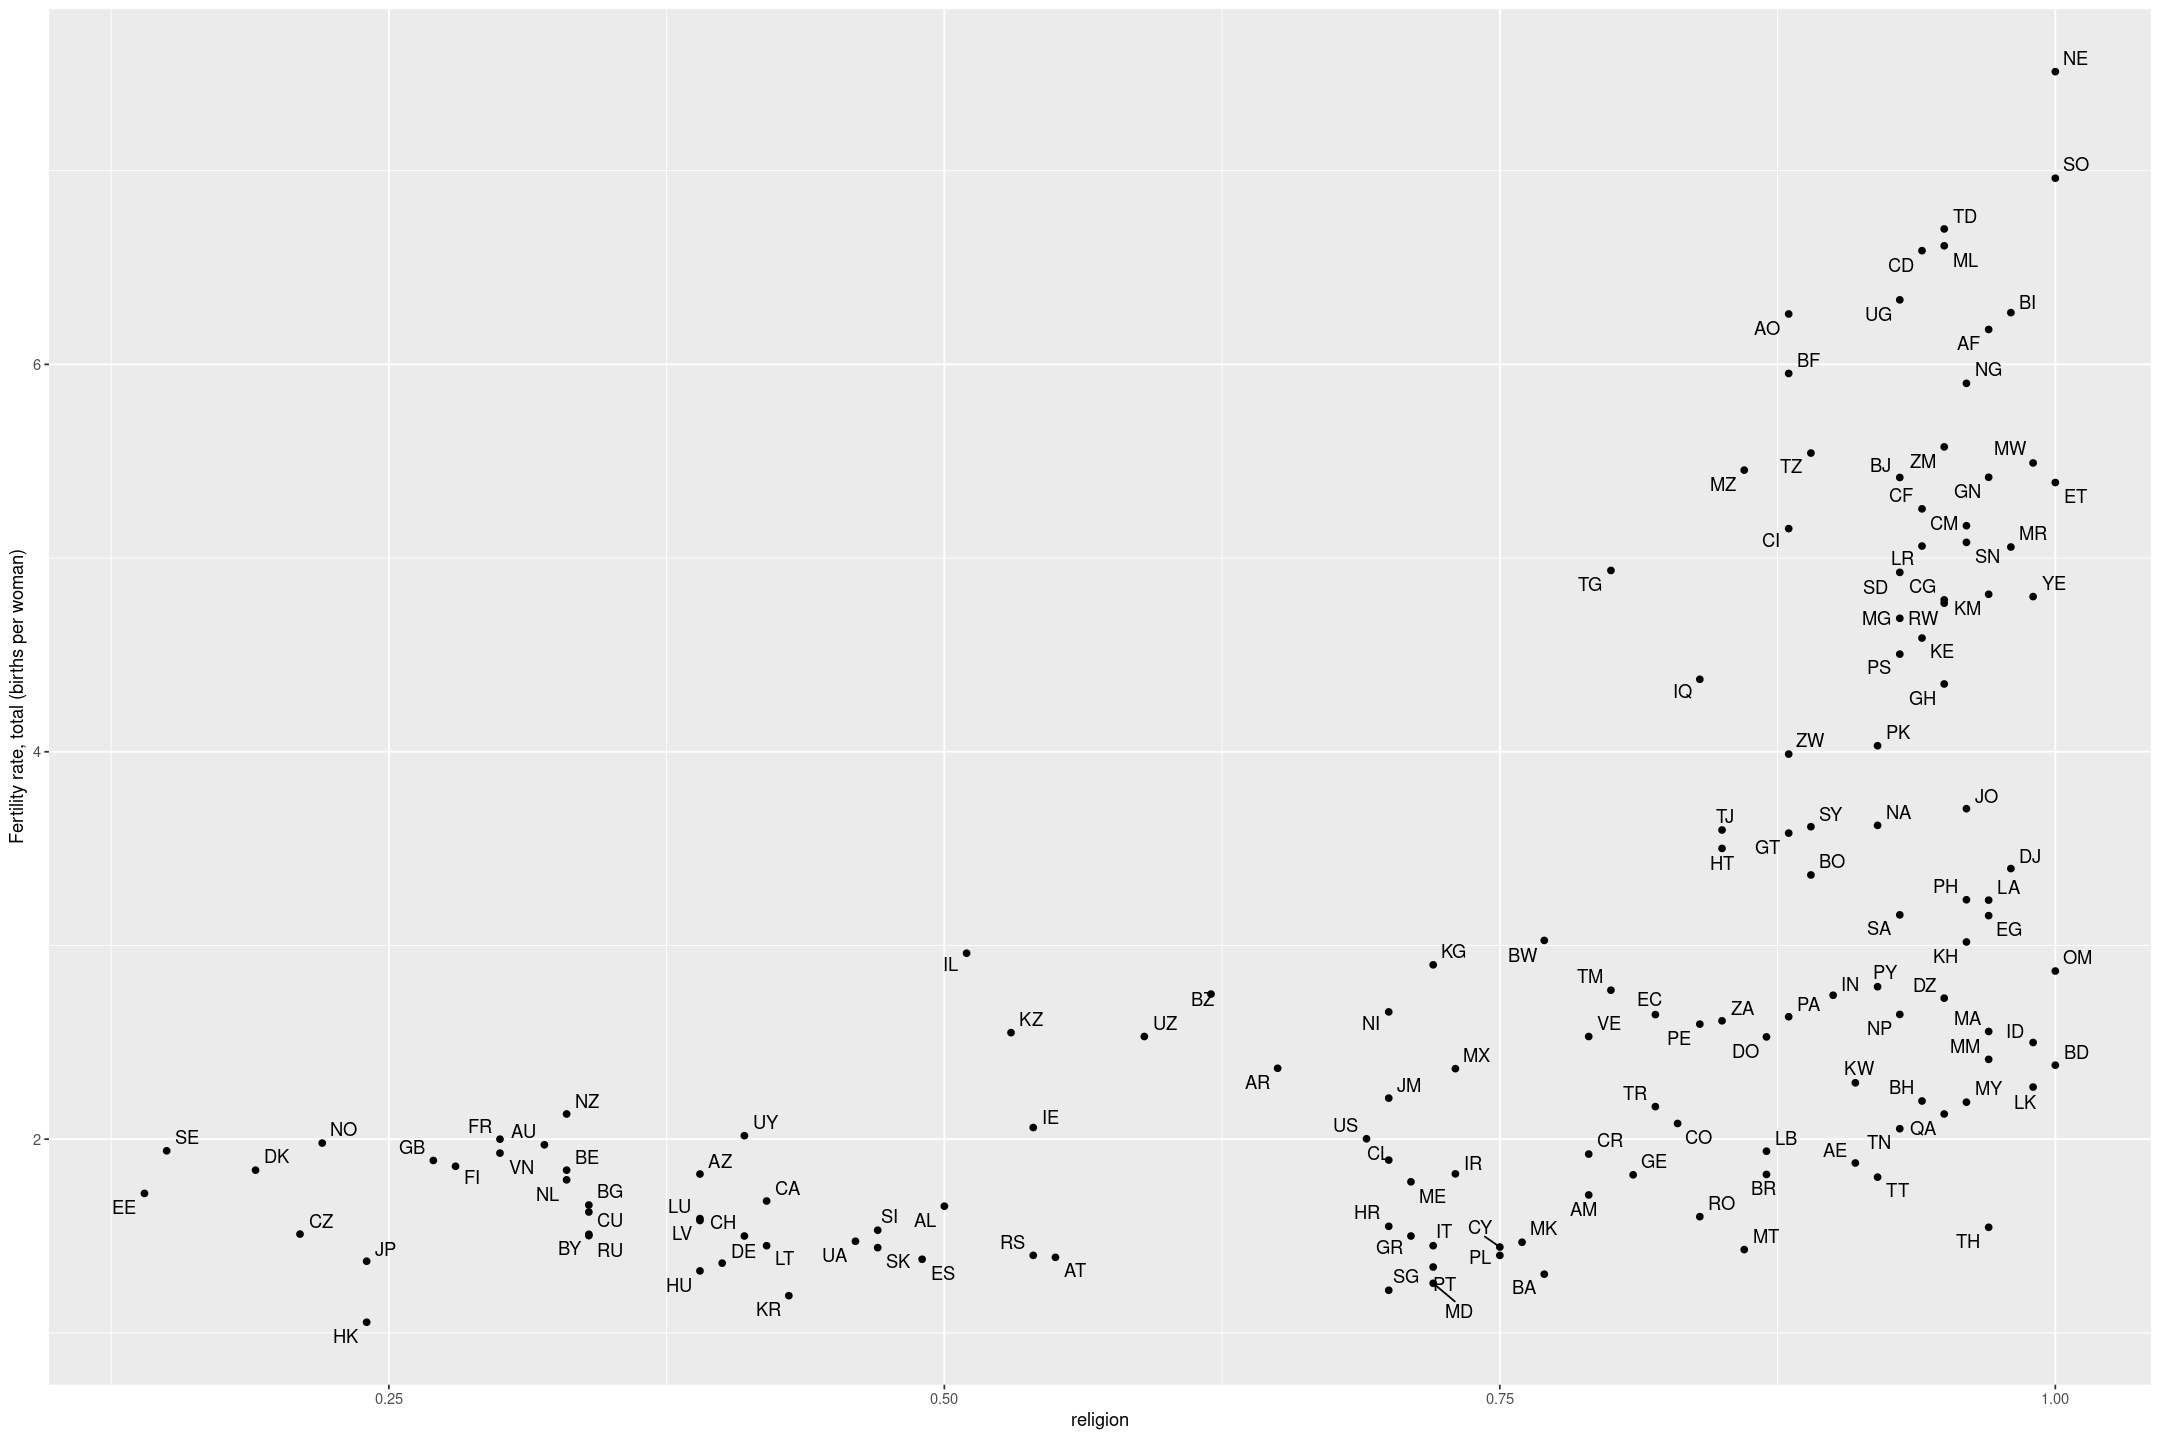

In [121]:
religion_fertility %>% gf_point(fertility ~ religion) + ggrepel::geom_text_repel(aes(label=iso2c))

In [122]:
religion_fertility %>% arrange(desc(fertility)) %>% head()

,rank,country,religion,year,iso2c,fertility
,<int>,<fct>,<dbl>,<int>,<chr>,<dbl>
1,145,Niger,1.00,2009,NE,7.511
2,147,Somalia,1.00,2009,SO,6.961
3,119,Chad,0.95,2009,TD,6.699
4,122,Mali,0.95,2009,ML,6.612
5,113,Democratic Republic of the Congo,0.94,2009,CD,6.587
6,104,Uganda,0.93,2008,UG,6.333


In [123]:
religion_fertility %>% arrange(fertility) %>% head()

,rank,country,religion,year,iso2c,fertility
,<int>,<fct>,<dbl>,<int>,<chr>,<dbl>
1,7,Hong Kong,0.24,2009,HK,1.055
2,29,South Korea,0.43,2008,KR,1.192
3,48,Singapore,0.70,2009,SG,1.220
4,54,Moldova,0.72,2008,MD,1.256
5,64,Bosnia and Herzegovina,0.77,2008,BA,1.303
6,22,Hungary,0.39,2009,HU,1.320


Log transforming fertility gives something closer to linear.

Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


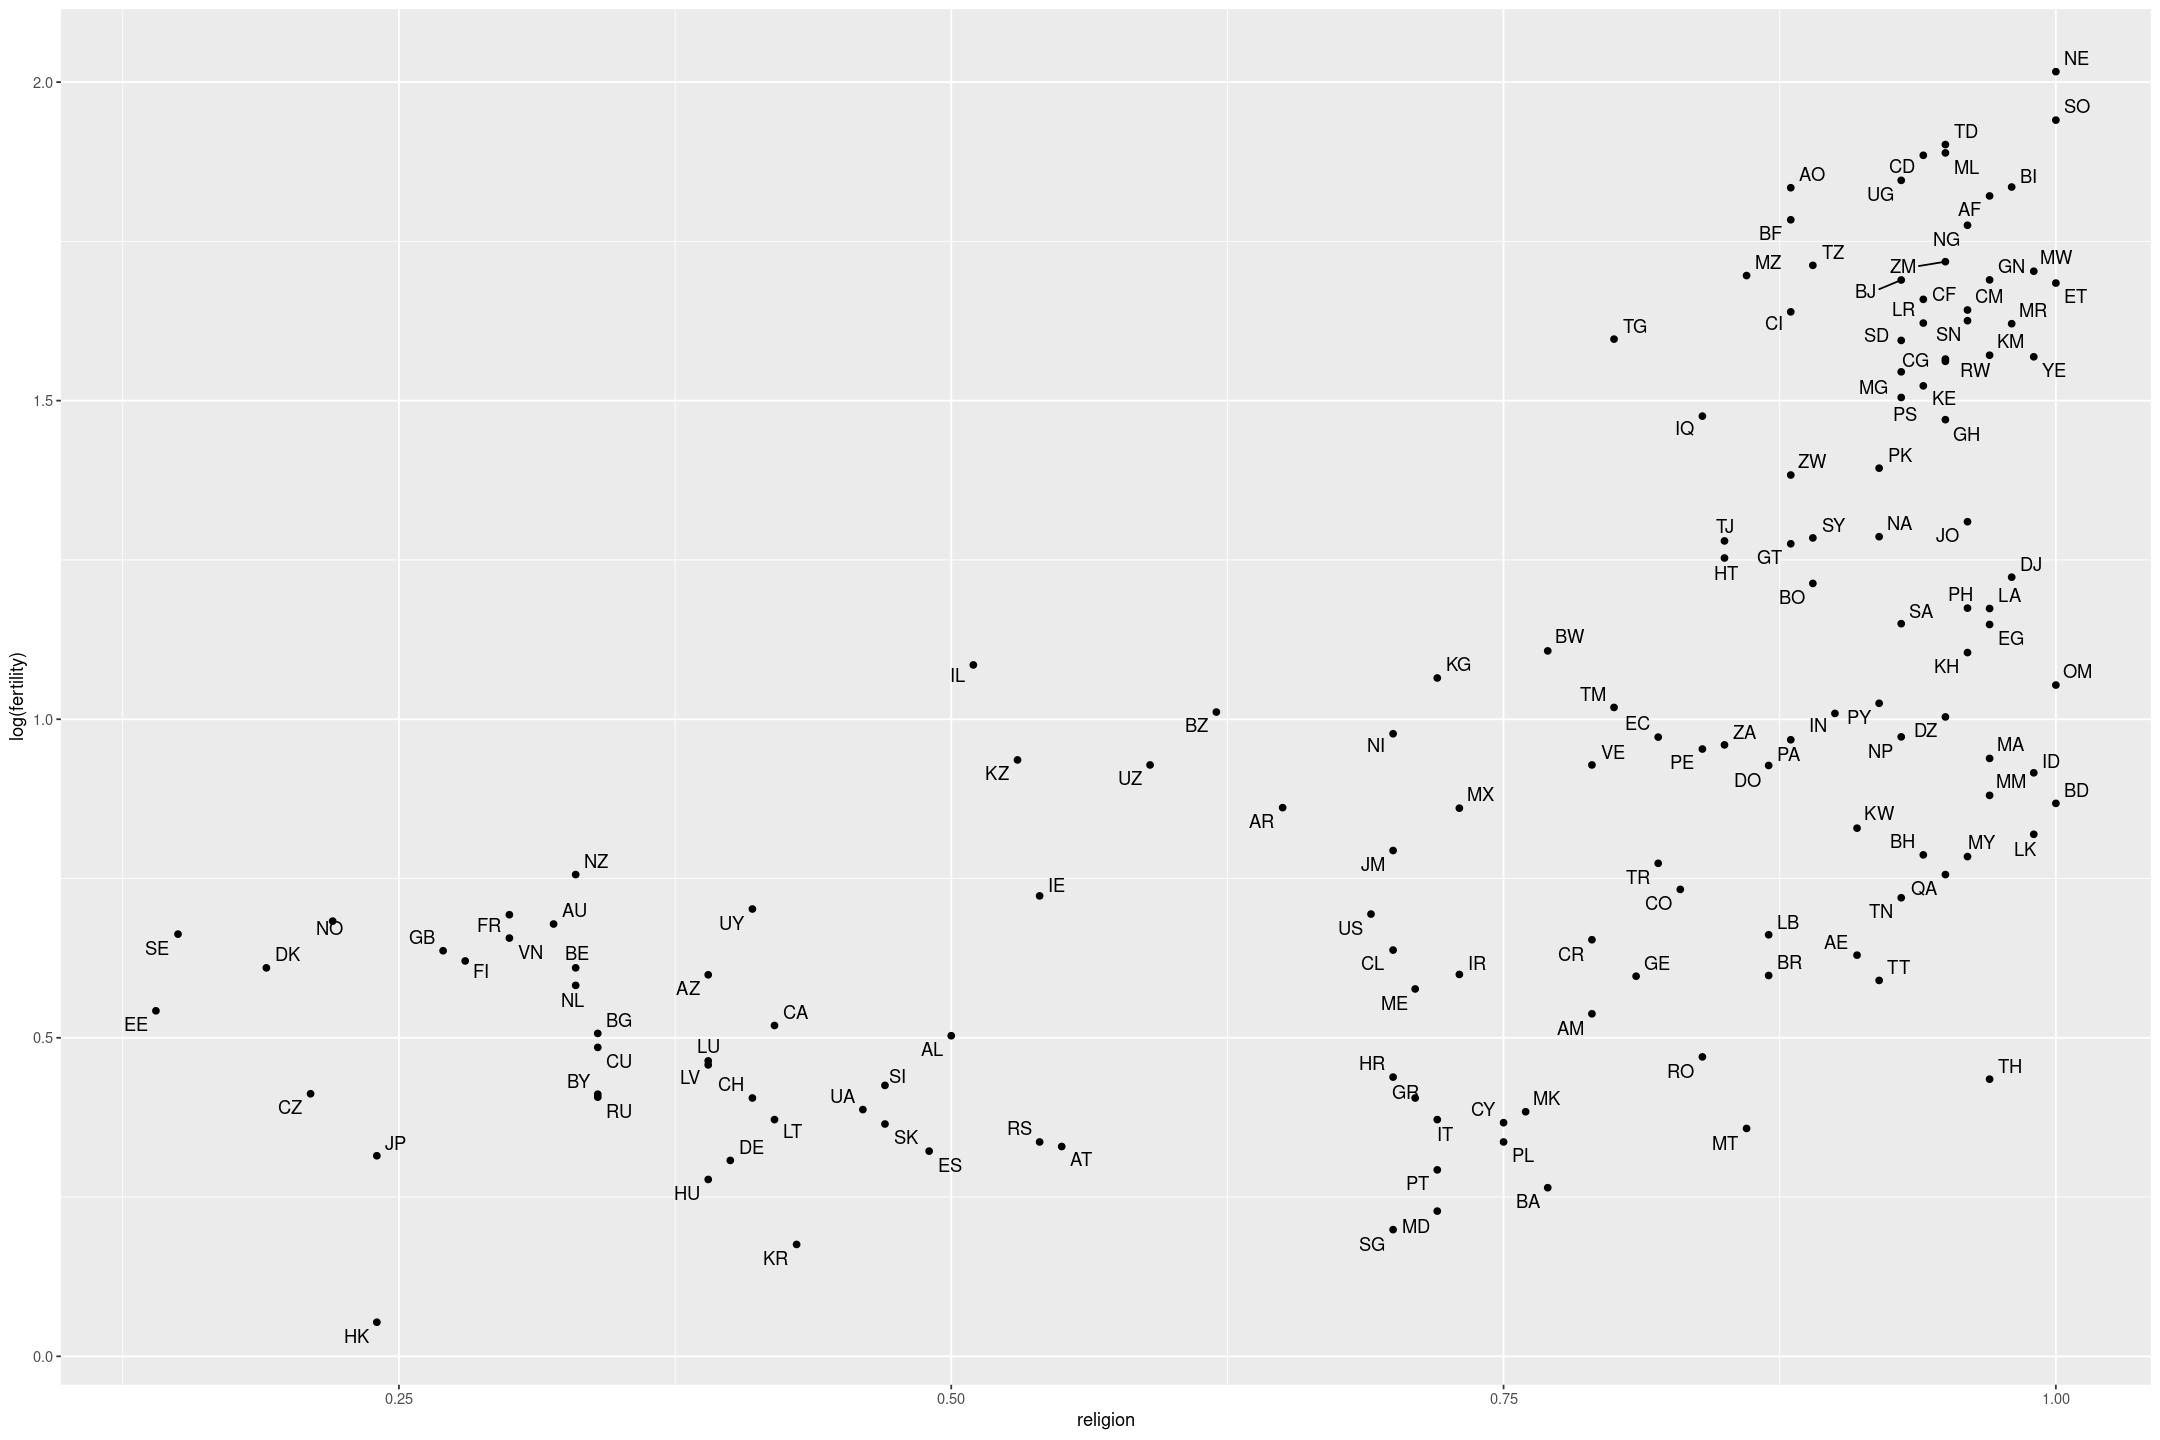

In [124]:
religion_fertility %>% gf_point(log(fertility) ~ religion) + ggrepel::geom_text_repel(aes(label=iso2c))

## Fitting a model

In [125]:
religion_fertility_model <- stan_glm(fertility ~ religion, data=religion_fertility)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.032496 seconds (Warm-up)
Chain 1:                0.048661 seconds (Sampling)
Chain 1:                0

In [126]:
print(religion_fertility_model)

stan_glm
 family:       gaussian [identity]
 formula:      fertility ~ religion
 observations: 145
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.1    0.3   
religion    3.9    0.4   

Auxiliary parameter(s):
      Median MAD_SD
sigma 1.3    0.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [127]:
model_intercept = coef(religion_fertility_model)[1]
model_slope = coef(religion_fertility_model)[2]

At low values it underestimates fertility, at high values it works well.

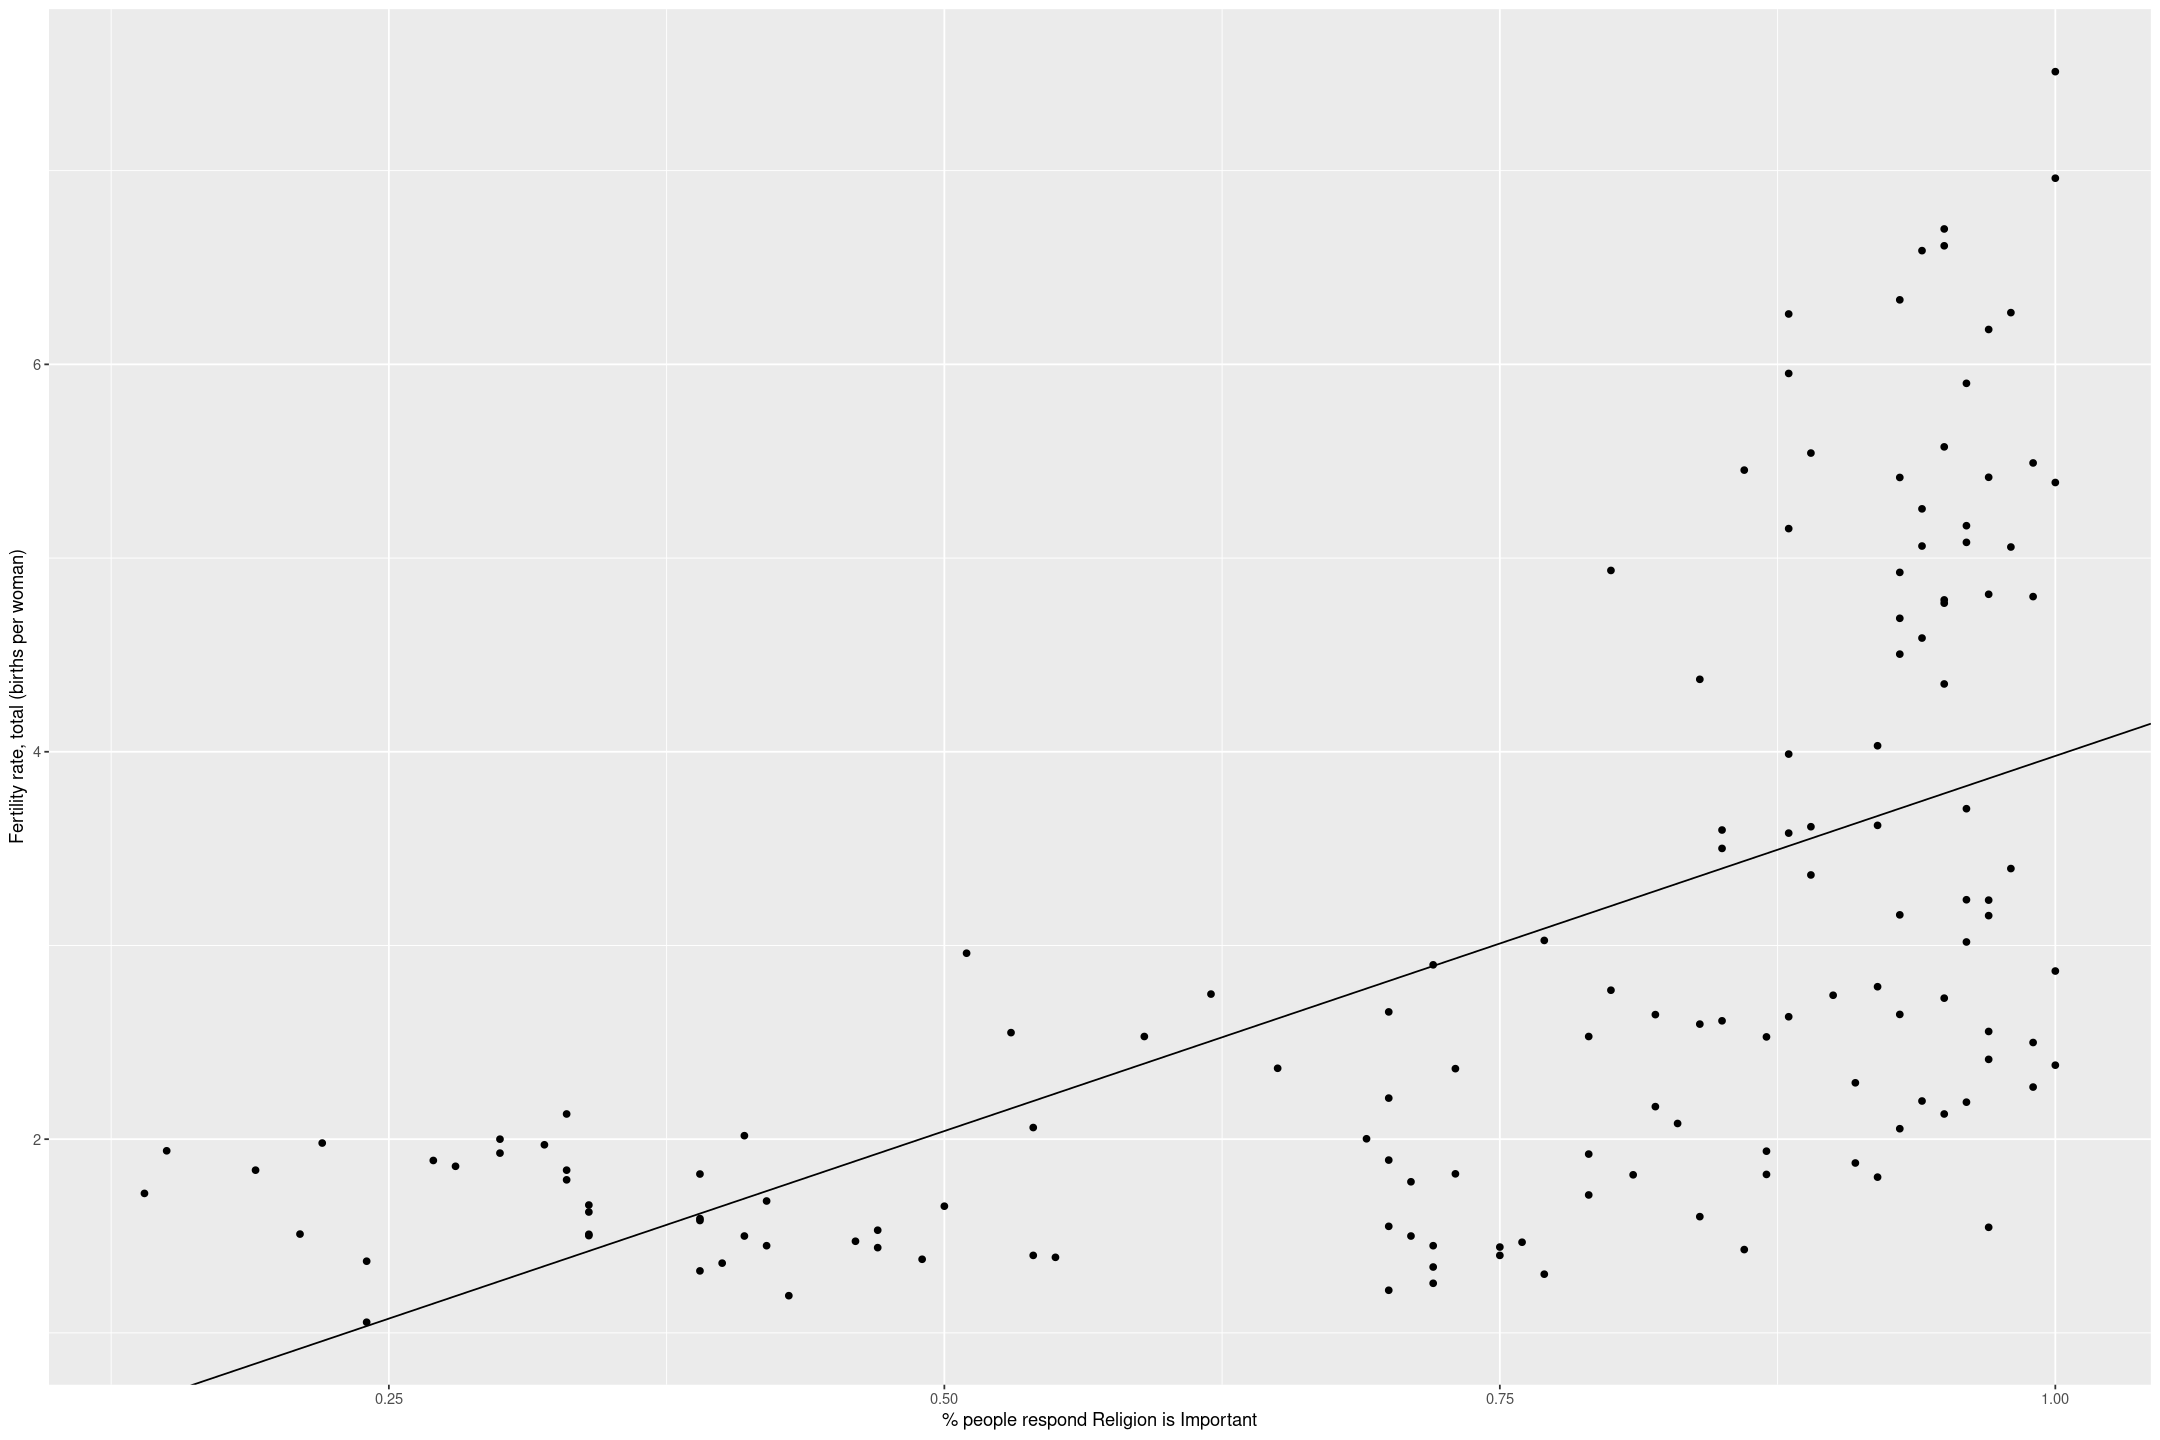

In [128]:
religion_fertility %>%
gf_point(fertility ~ religion) +
geom_abline(intercept=model_intercept, slope=model_slope) +
xlab("% people respond Religion is Important")

In [129]:
model_slope
model_intercept

religion 
3.872787

(Intercept) 
  0.1056556

The model says that 1 percentage point increase in people who say that religion is important in daily life is associated with a 0.04 percentage point increase in the fertility rate.

If no one believes religion is important in daily life the fertility rate is predicted to be 0.09 births per baby.
This is highly unlikely; we can already see the data not fitting well at low values.
The extrapolation is poor.

Interesting is the point at which population declines below replacement (neglecting immigration); 2 births per woman.

This is at 49%

In [130]:
(2 - model_intercept) / model_slope

(Intercept) 
  0.4891424

## Prediction

We can use the missing country of Taiwan as a prediction

In [131]:
importance_religion %>% filter(iso2c == 'TW')

rank,country,yes,no,year,iso2c
<int>,<fct>,<dbl>,<dbl>,<int>,<chr>
30,Taiwan,0.45,0.54,2009,TW


Predicted fertility

In [132]:
pred <- model_intercept + model_slope * 0.45
pred

(Intercept) 
    1.84841

It seems like the [actual number](https://www.macrotrends.net/countries/TWN/taiwan/fertility-rate) in 2009 was 1.06, quite a bit lower.
But it had been undergoing steep decline; 10 years earlier it was 1.69.

The prediction is still within a standard deviations, which is reasonable.

In [133]:
(log(pred) - log(1.06)) / sigma(religion_fertility_model)

(Intercept) 
  0.4328967

## Simulating Draws

How well does the model match the data?

In [134]:
N <- 100
sample_x <- runif(N)

sample_y <- model_intercept + model_slope * sample_x + rnorm(N, sd=sigma(religion_fertility_model))

religion_fertility_sample <- data.frame(religion=sample_x, fertility=sample_y)

Note that this doesn't look gret at low values it's over predicted and over dispersed, at high values it's underdispersed.

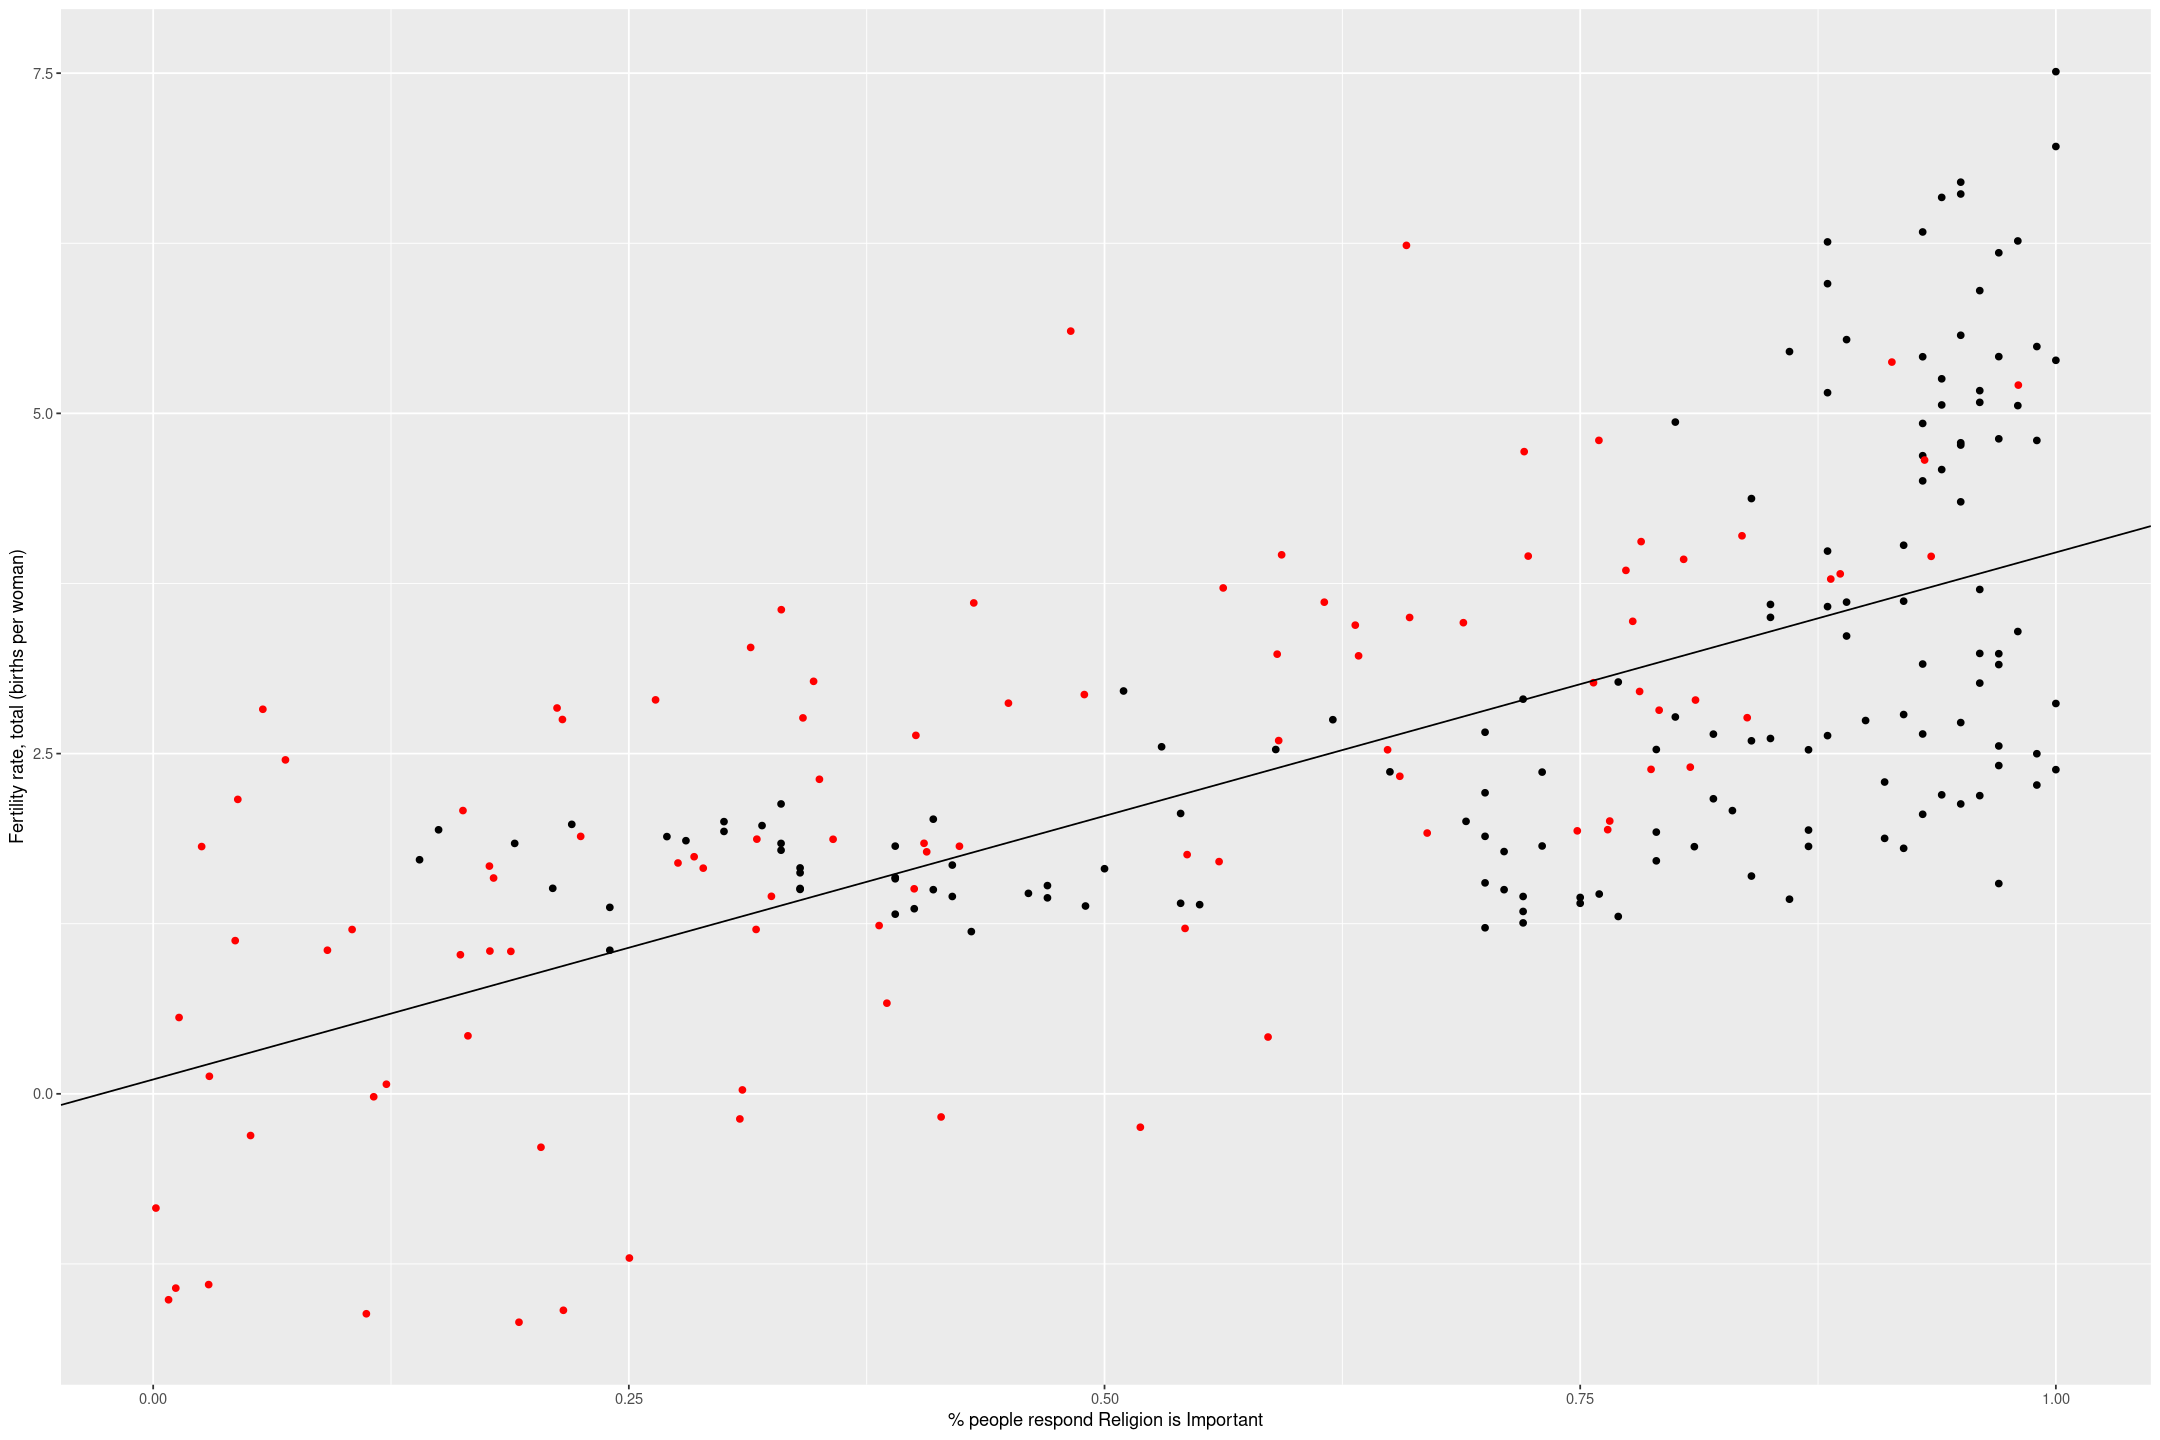

In [135]:
religion_fertility %>% 
gf_point(fertility ~ religion) %>% 
gf_point(data=religion_fertility_sample, color="red") + 
geom_abline(slope=model_slope, intercept=model_intercept) +
xlab("% people respond Religion is Important")

# Converence as sample size increases
Set up a simulation study such as in Section 7.2, wirting the entire simulation as a function, with one of the arguments being the number of data points $n$.
Compute the simulation for n = 10, 30, 100, 300, 1000, 3000, 10000, and 30000, for each displaying the estimate and standard error.
Graph these to show the increasing stability as n increases.

## Solution

Let's fit the line 3.9 x + 0.09 with standard deviation 1.3 to uniform points in `[0,1]`.

In [136]:
runif(10)

[1] 0.26178657 0.68386103 0.18259094 0.29860183 0.35774215 0.23058645
 [7] 0.85325192 0.55196349 0.09163643 0.06334547

In [137]:
a <- 0.09
b <- 3.9
s <- 3.9

simulate_fit <- function(n) {
    x <- runif(n)
    y <- rnorm(n, a + b*x, s)
    fake <- data.frame(x, y)
    
    fit <- stan_glm(y ~ x, data=fake, refresh=0)
    
    c(b_hat=coef(fit)["x"], b_se=se(fit)["x"])
    
}

In [138]:
n_vars = c(10, 30)
n_powers = seq(0, 3)

ns <- rep(n_vars, length(n_powers)) * rep(10^n_powers, each=length(n_vars))

b_hats <- rep(NA, length(ns))
b_ses <- rep(NA, length(ns))

ns

[1]    10    30   100   300  1000  3000 10000 30000

This is a little slow

In [139]:
for (i in seq(length(ns))) {
    fit <- simulate_fit(ns[i])
    b_hats[i] <- fit[1]
    b_ses[i] <- fit[2]
}

In [140]:
fits <- data.frame(n=ns, b_hat=b_hats, b_se=b_ses)

fits

n,b_hat,b_se
<dbl>,<dbl>,<dbl>
10,8.728581,4.70074114
30,4.306577,2.75872480
100,2.889003,1.09145110
300,4.087542,0.76389626
1000,3.847911,0.41315267
3000,3.674908,0.26096230
10000,3.710847,0.13125932
30000,3.902223,0.07938505


In [141]:
geom_errorbar(aes(ymin=len-sd, ymax=len+sd), width=.2,
                 position=position_dodge(.9)) 

mapping: ymin = ~len - sd, ymax = ~len + sd 
geom_errorbar: na.rm = FALSE, orientation = NA, width = 0.2
stat_identity: na.rm = FALSE
position_dodge 

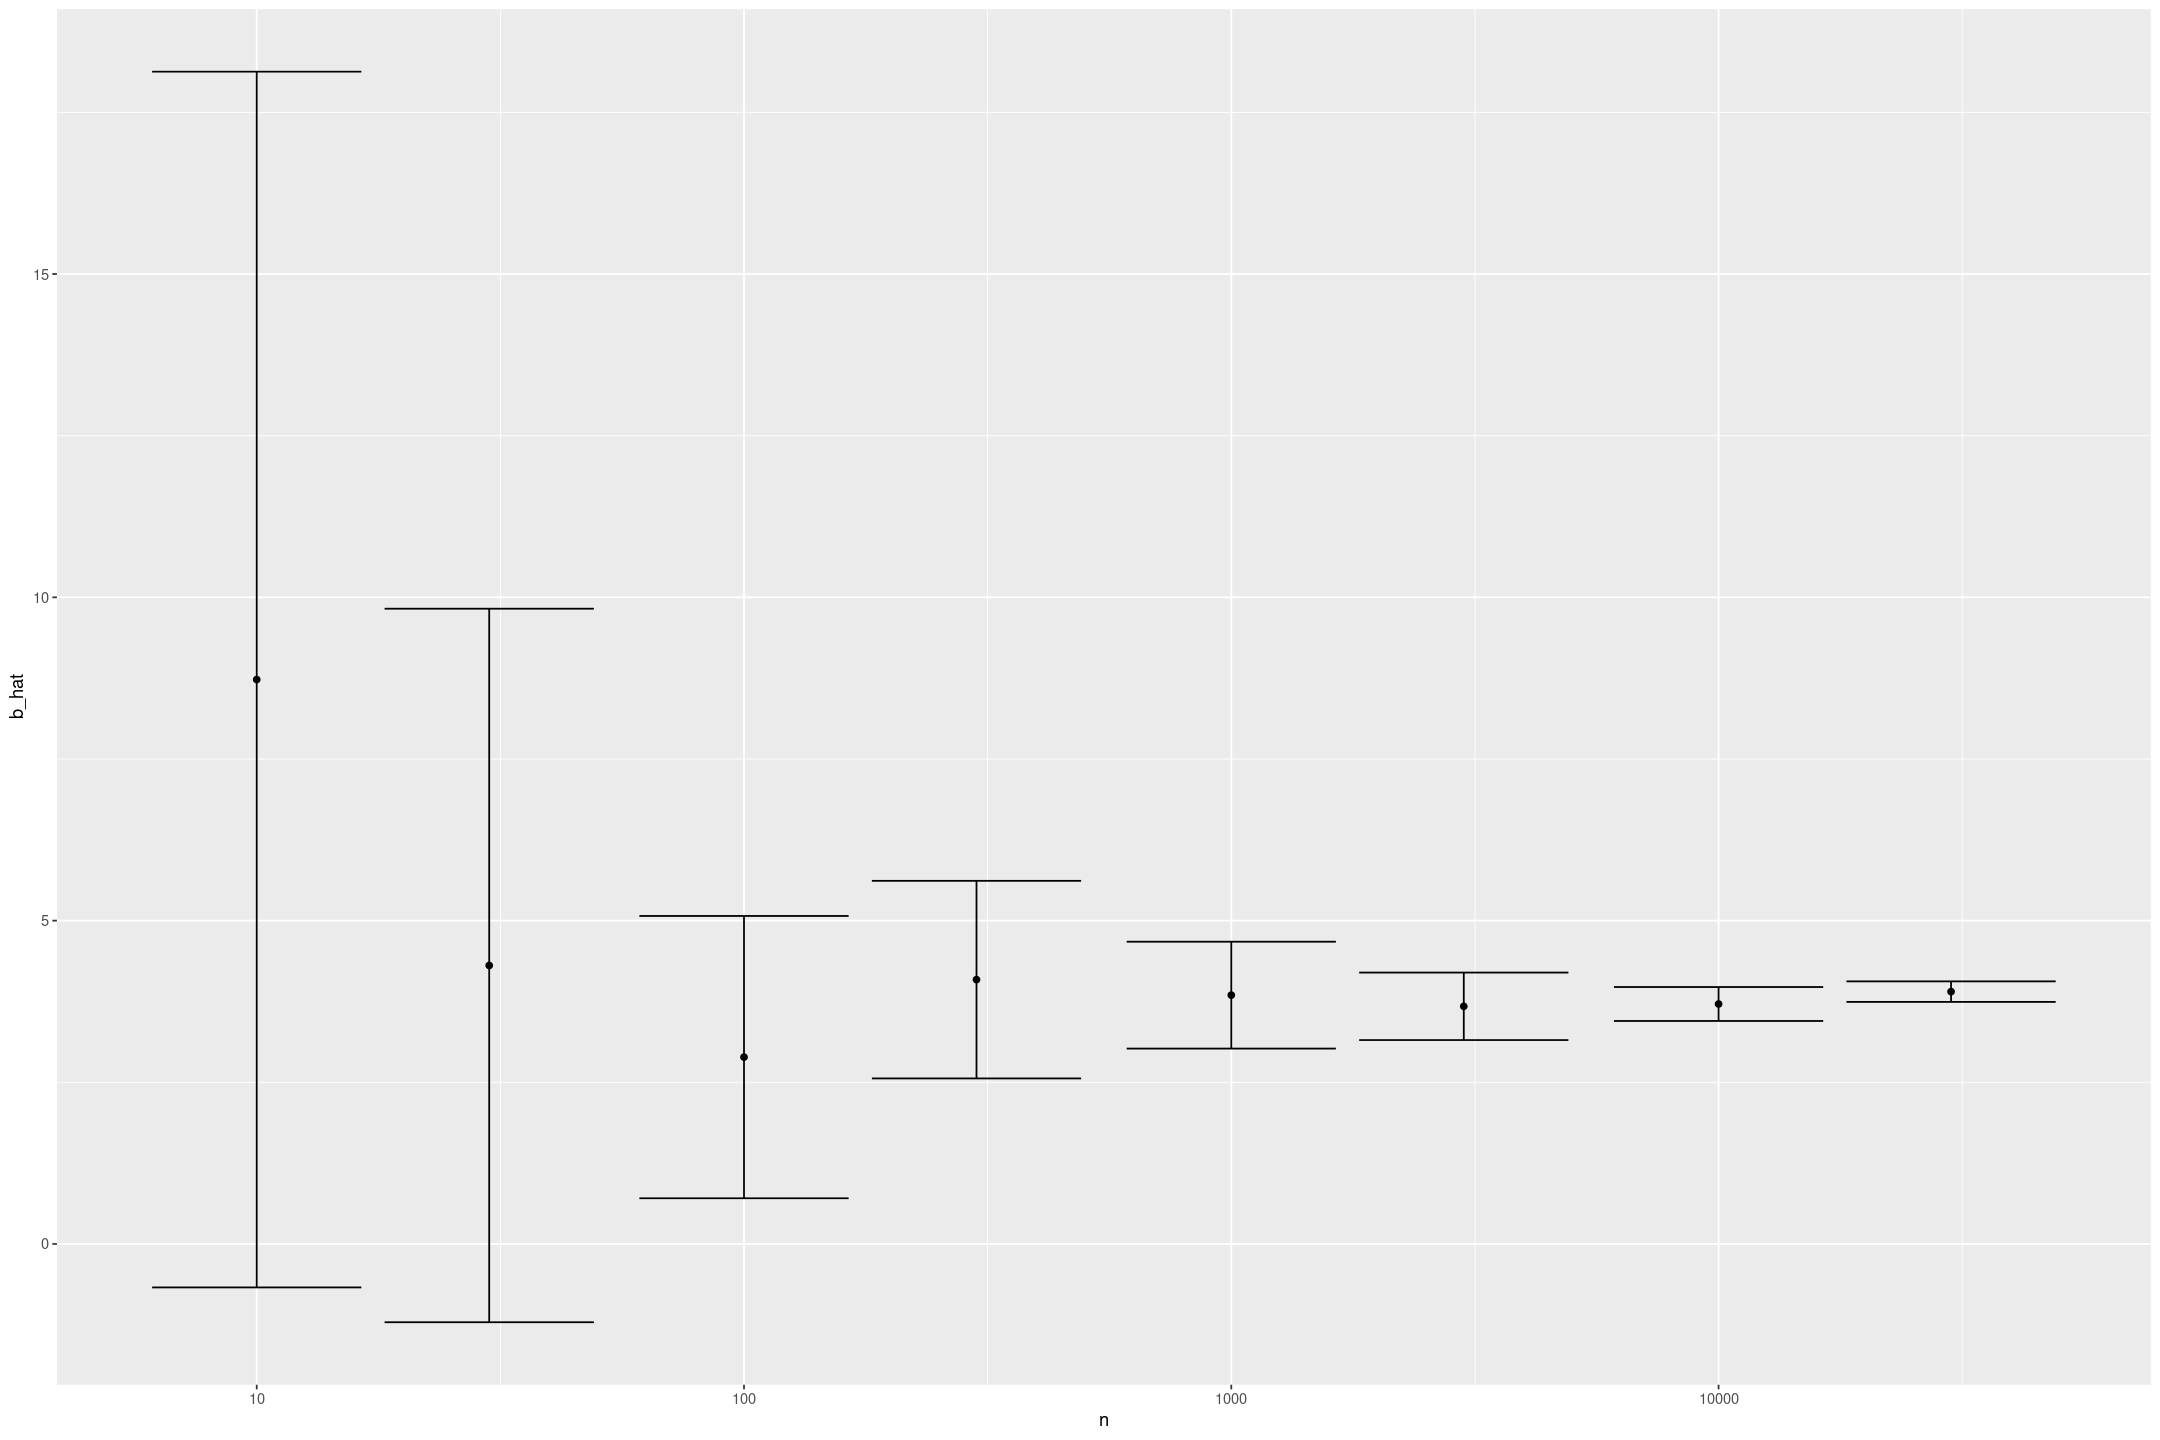

In [142]:
fits %>% gf_point(b_hat ~ n) %>% gf_errorbar(ymin=~b_hat - 2*b_se, ymax = ~b_hat + 2*b_se) + scale_x_log10()

## Checking coverage intervals

In [143]:
fit10 <- replicate(100, simulate_fit(10))

In [144]:
df_fit10 = as.data.frame(t(fit10)) %>%
mutate(covers68 = (b_hat.x - b_se.x < b) & (b < b_hat.x + b_se.x),
       covers95 = (b_hat.x - 2 * b_se.x < b) & (b < b_hat.x + 2 * b_se.x))
df_fit10

b_hat.x,b_se.x,covers68,covers95
<dbl>,<dbl>,<lgl>,<lgl>
13.37868418,8.953036,FALSE,TRUE
17.55421790,9.962144,FALSE,TRUE
0.17855856,5.257330,TRUE,TRUE
3.37134795,2.906783,TRUE,TRUE
-0.72808327,5.432964,TRUE,TRUE
8.10506258,8.109808,TRUE,TRUE
5.08246900,3.339441,TRUE,TRUE
-4.48887092,3.929722,FALSE,FALSE
-0.54793543,4.280765,FALSE,TRUE


The 68% and 95% confidence intervals contain the true value at close to their purported proportions.

In [145]:
mean(df_fit10$covers68)

[1] 0.63

In [146]:
mean(df_fit10$covers95)

[1] 0.94

# Formulating comparisons as regression models
Take the election forecasting model and simplify it y creating a binary predictor defined as $ x = 0 $ if income growth is less than 2% and $ x = 1 $ if income growth is more than 2%.

In [147]:
filename <- "./data/ElectionsEconomy/hibbs.dat"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat')
hibbs <- read.table("./data/ElectionsEconomy/hibbs.dat", header=TRUE)

In [148]:
hibbs <- hibbs %>% mutate(high_growth = growth >= 2)
hibbs

year,growth,vote,inc_party_candidate,other_candidate,high_growth
<int>,<dbl>,<dbl>,<fct>,<fct>,<lgl>
1952,2.40,44.60,Stevenson,Eisenhower,TRUE
1956,2.89,57.76,Eisenhower,Stevenson,TRUE
1960,0.85,49.91,Nixon,Kennedy,FALSE
1964,4.21,61.34,Johnson,Goldwater,TRUE
1968,3.02,49.60,Humphrey,Nixon,TRUE
1972,3.62,61.79,Nixon,McGovern,TRUE
1976,1.08,48.95,Ford,Carter,FALSE
1980,-0.39,44.70,Carter,Reagan,FALSE
1984,3.86,59.17,Reagan,Mondale,TRUE


## Compute the difference in incumbent pary's vote share on average, comparing those two groups of elections, and determine the standard error for this difference.

In [149]:
high_growth_vote <- subset(hibbs, hibbs$high_growth)$vote
low_growth_vote <- subset(hibbs, !hibbs$high_growth)$vote

In [150]:
high_growth_incumbent_share <- mean(high_growth_vote)
low_growth_incumbent_share <- mean(low_growth_vote)
high_growth_incumbent_share - low_growth_incumbent_share

[1] 5.5075

In [151]:
high_growth_incumbent_share_error <- sd(high_growth_vote) / sqrt(length(high_growth_vote))
low_growth_incumbent_share_error <- sd(low_growth_vote) / sqrt(length(low_growth_vote))
sqrt(high_growth_incumbent_share_error^2 + low_growth_incumbent_share_error^2)

[1] 2.502052

## Regress incumbent party's vote share of income growth and check that the resulting estimate and standard error are the same as above.

In [152]:
model = stan_glm(vote ~ high_growth, data=hibbs, refresh=0, prior_intercept=NULL, prior=NULL, prior_aux=NULL)

As in the previous part the point estimate is 5.5, and the sd is estimated to be 2.6 (close to the 2.5 estimated above).

In [153]:
print(model)

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ high_growth
 observations: 16
 predictors:   2
------
                Median MAD_SD
(Intercept)     49.3    2.0  
high_growthTRUE  5.4    2.7  

Auxiliary parameter(s):
      Median MAD_SD
sigma 5.3    1.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


# Comparing simulated data to assumed parameter values

## Part a
Simulate 100 data points from the model, $ y = 2 + 3 x + \rm{error} $, with predictors x drawn from a uniform distribution from 0 to 20, and with independent errors drawn from the normal distribution with mean 0 and standard deviation 5.
Save x and y into a data frame called fake.
Fit the model `stan_glm(y ~ x, data=fake)`.
Plot the data and fitted regression line.

In [154]:
n <- 100
x <- runif(n, min=0, max=20)
y <- 2 + 3*x + rnorm(n, 0, 5)

fake <- data.frame(x, y)
head(fake)

,x,y
,<dbl>,<dbl>
1,6.885868,18.842800
2,9.277239,24.573088
3,3.913789,14.514221
4,3.491971,7.213347
5,3.248290,18.047767
6,6.667772,25.408855


In [155]:
fit <- stan_glm(y ~ x, data=fake, refresh=0)
print(fit)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.4    0.9   
x           3.1    0.1   

Auxiliary parameter(s):
      Median MAD_SD
sigma 5.2    0.4   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [156]:
model_intercept = coef(fit)['(Intercept)']
model_slope = coef(fit)['x']

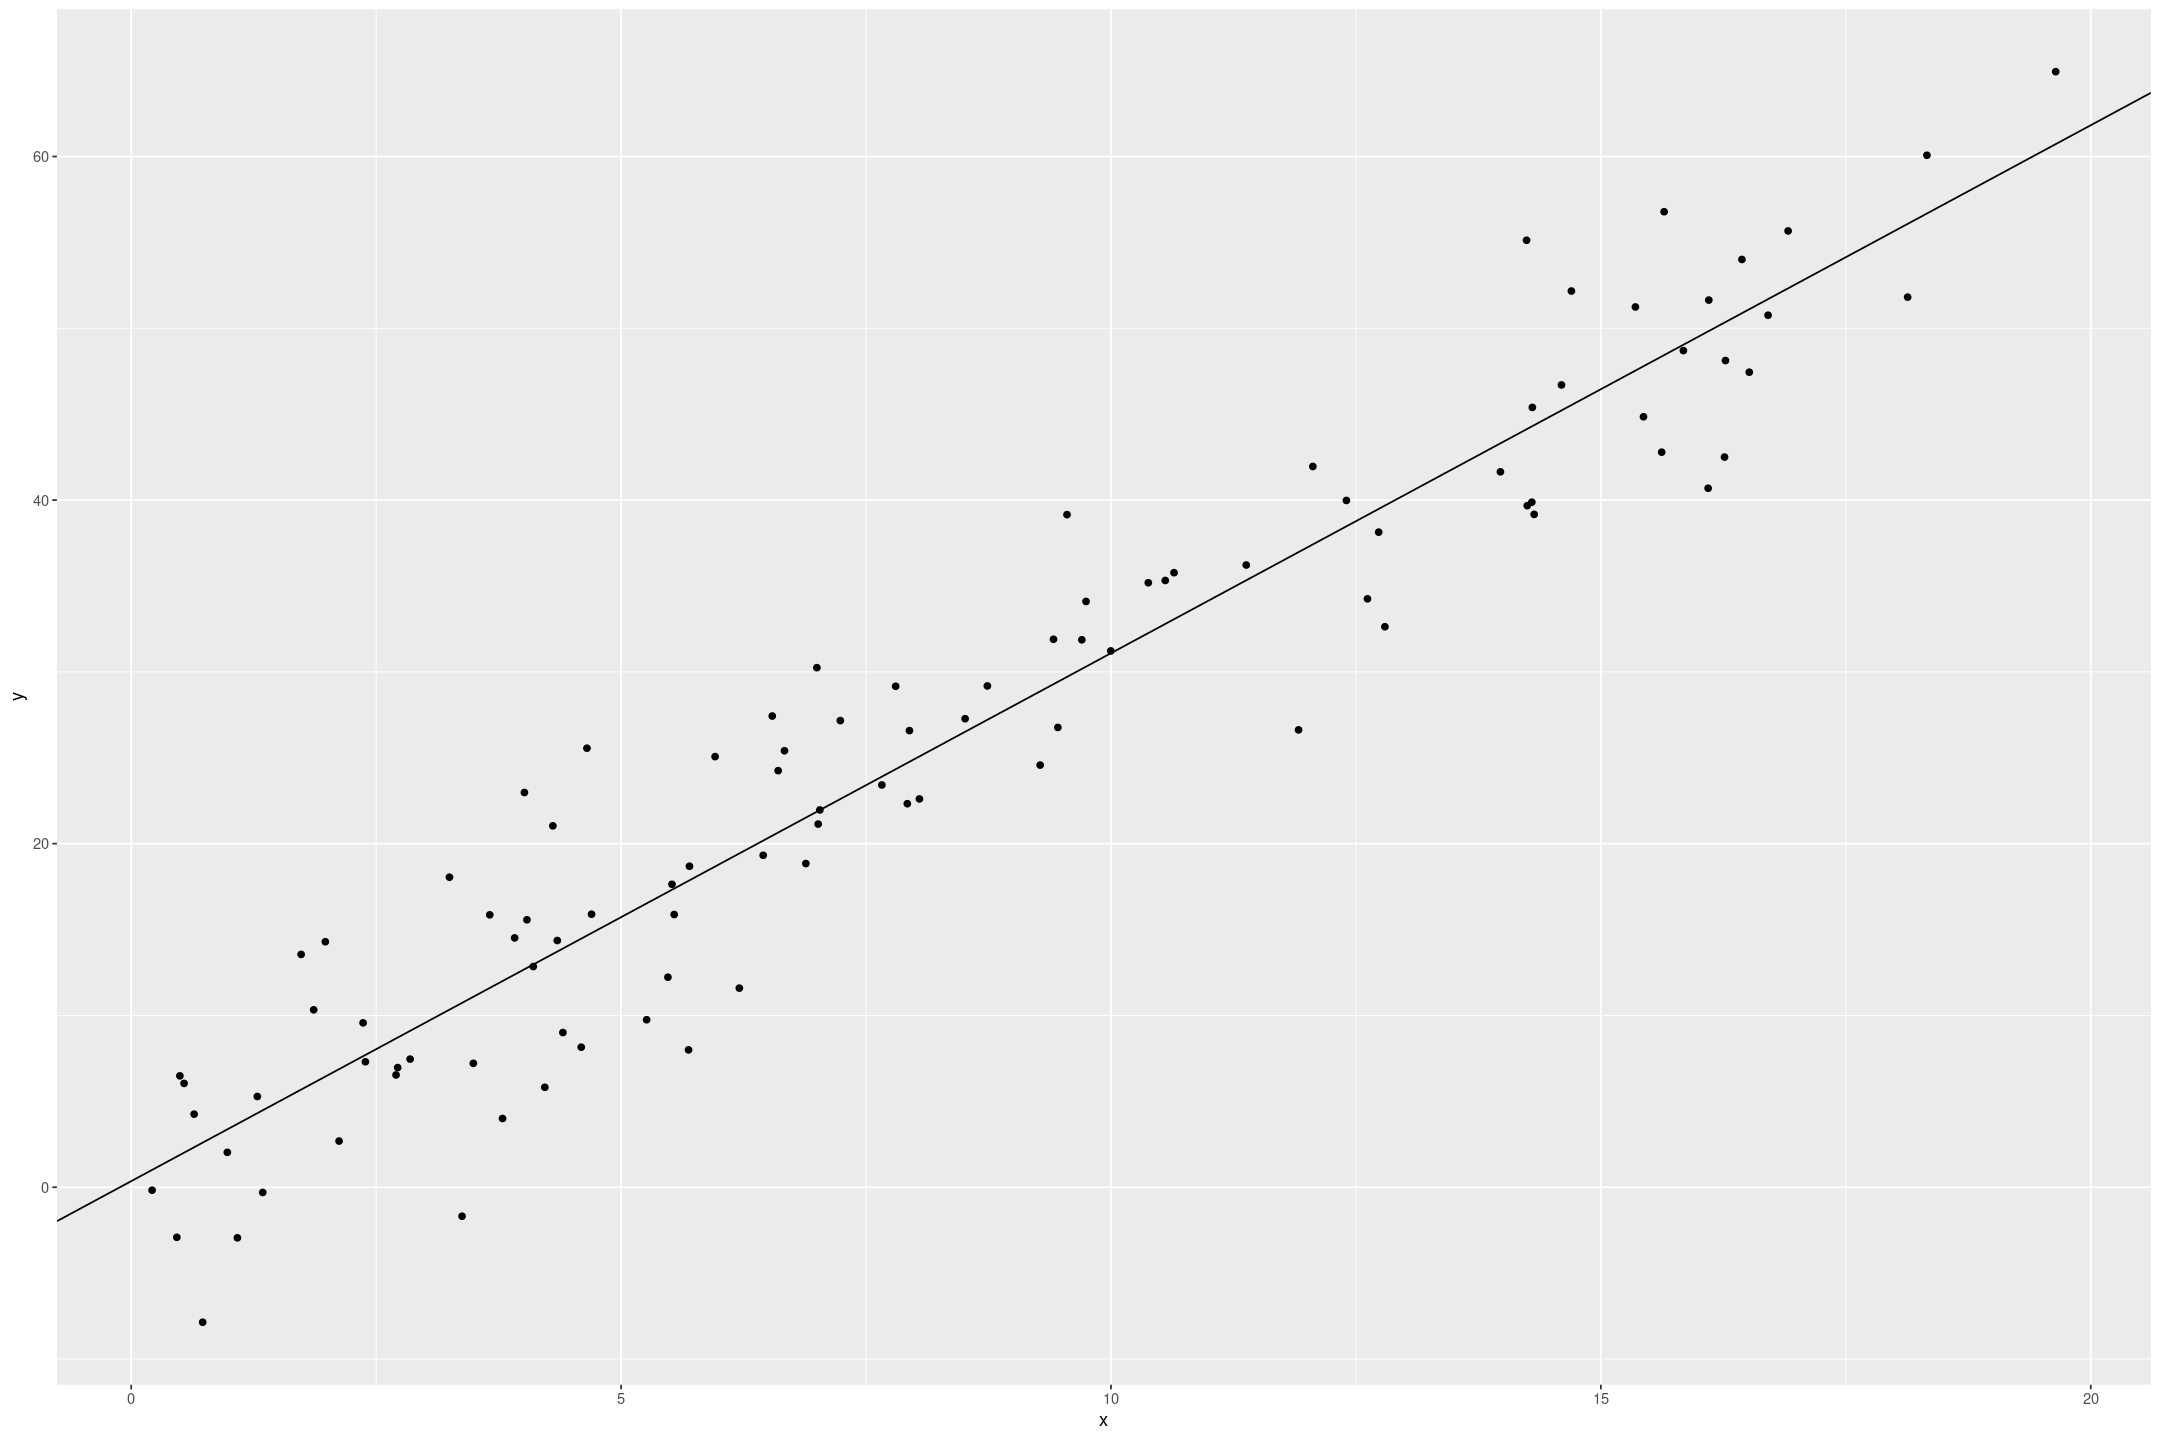

In [157]:
fake %>% gf_point(y~x) + geom_abline(slope=model_slope, intercept=model_intercept)

## Part b
Check that the estimated coefficients from the fitted model are reasonably closed to the assumed true values.
What does "reasonably close" mean in this context?

The slope is close to 3 and the intercept is a bit over 2; well within a standard deviation.

This seems reasonable.

In [158]:
print(fit)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.4    0.9   
x           3.1    0.1   

Auxiliary parameter(s):
      Median MAD_SD
sigma 5.2    0.4   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


# Sampling distribution
Repeat the steps of the previous exercise 1000 times (omitting the plotting).
Check that the coefficient estimates are approximately unbiased, that their standard deviation in the sampling distribution are approximately equal to their standard errors, and that approximately 95% of the estimate +/- 2 standard error intervals contain the true parameter values.

In [159]:
simulate_sample_fit <- function() {
    n <- 100
    x <- runif(n, min=0, max=20)
    y <- 2 + 3*x + rnorm(n, 0, 5)

    fake <- data.frame(x, y)
    fit <- stan_glm(y ~ x, data=fake, refresh=0)
    c(coef(fit)['x'], sd=se(fit)['x'], coef(fit)['(Intercept)'],  sd=se(fit)['(Intercept)'])
}

This may take a while

In [160]:
samples <- replicate(1000, simulate_sample_fit())

In [161]:
df_sample <- samples %>% t() %>% as.data.frame()
names(df_sample) <- c('x', 'x_sd', 'c', 'c_sd')
df_sample

x,x_sd,c,c_sd
<dbl>,<dbl>,<dbl>,<dbl>
3.121710,0.07895932,0.2496851,0.9578747
2.920227,0.08137273,2.8657645,0.8996512
2.868404,0.09614530,3.4528273,1.1044362
3.044568,0.08405638,0.5362494,0.9720143
3.076062,0.08997564,1.6078006,0.9337023
2.996220,0.08336057,1.6169972,0.9386007
2.809406,0.08036485,4.2620665,0.9426502
3.067731,0.08775338,2.3802544,1.0845546
3.054713,0.07805973,1.2476301,0.9022827


## Coefficient estimates are approximately unbiased

### The slope

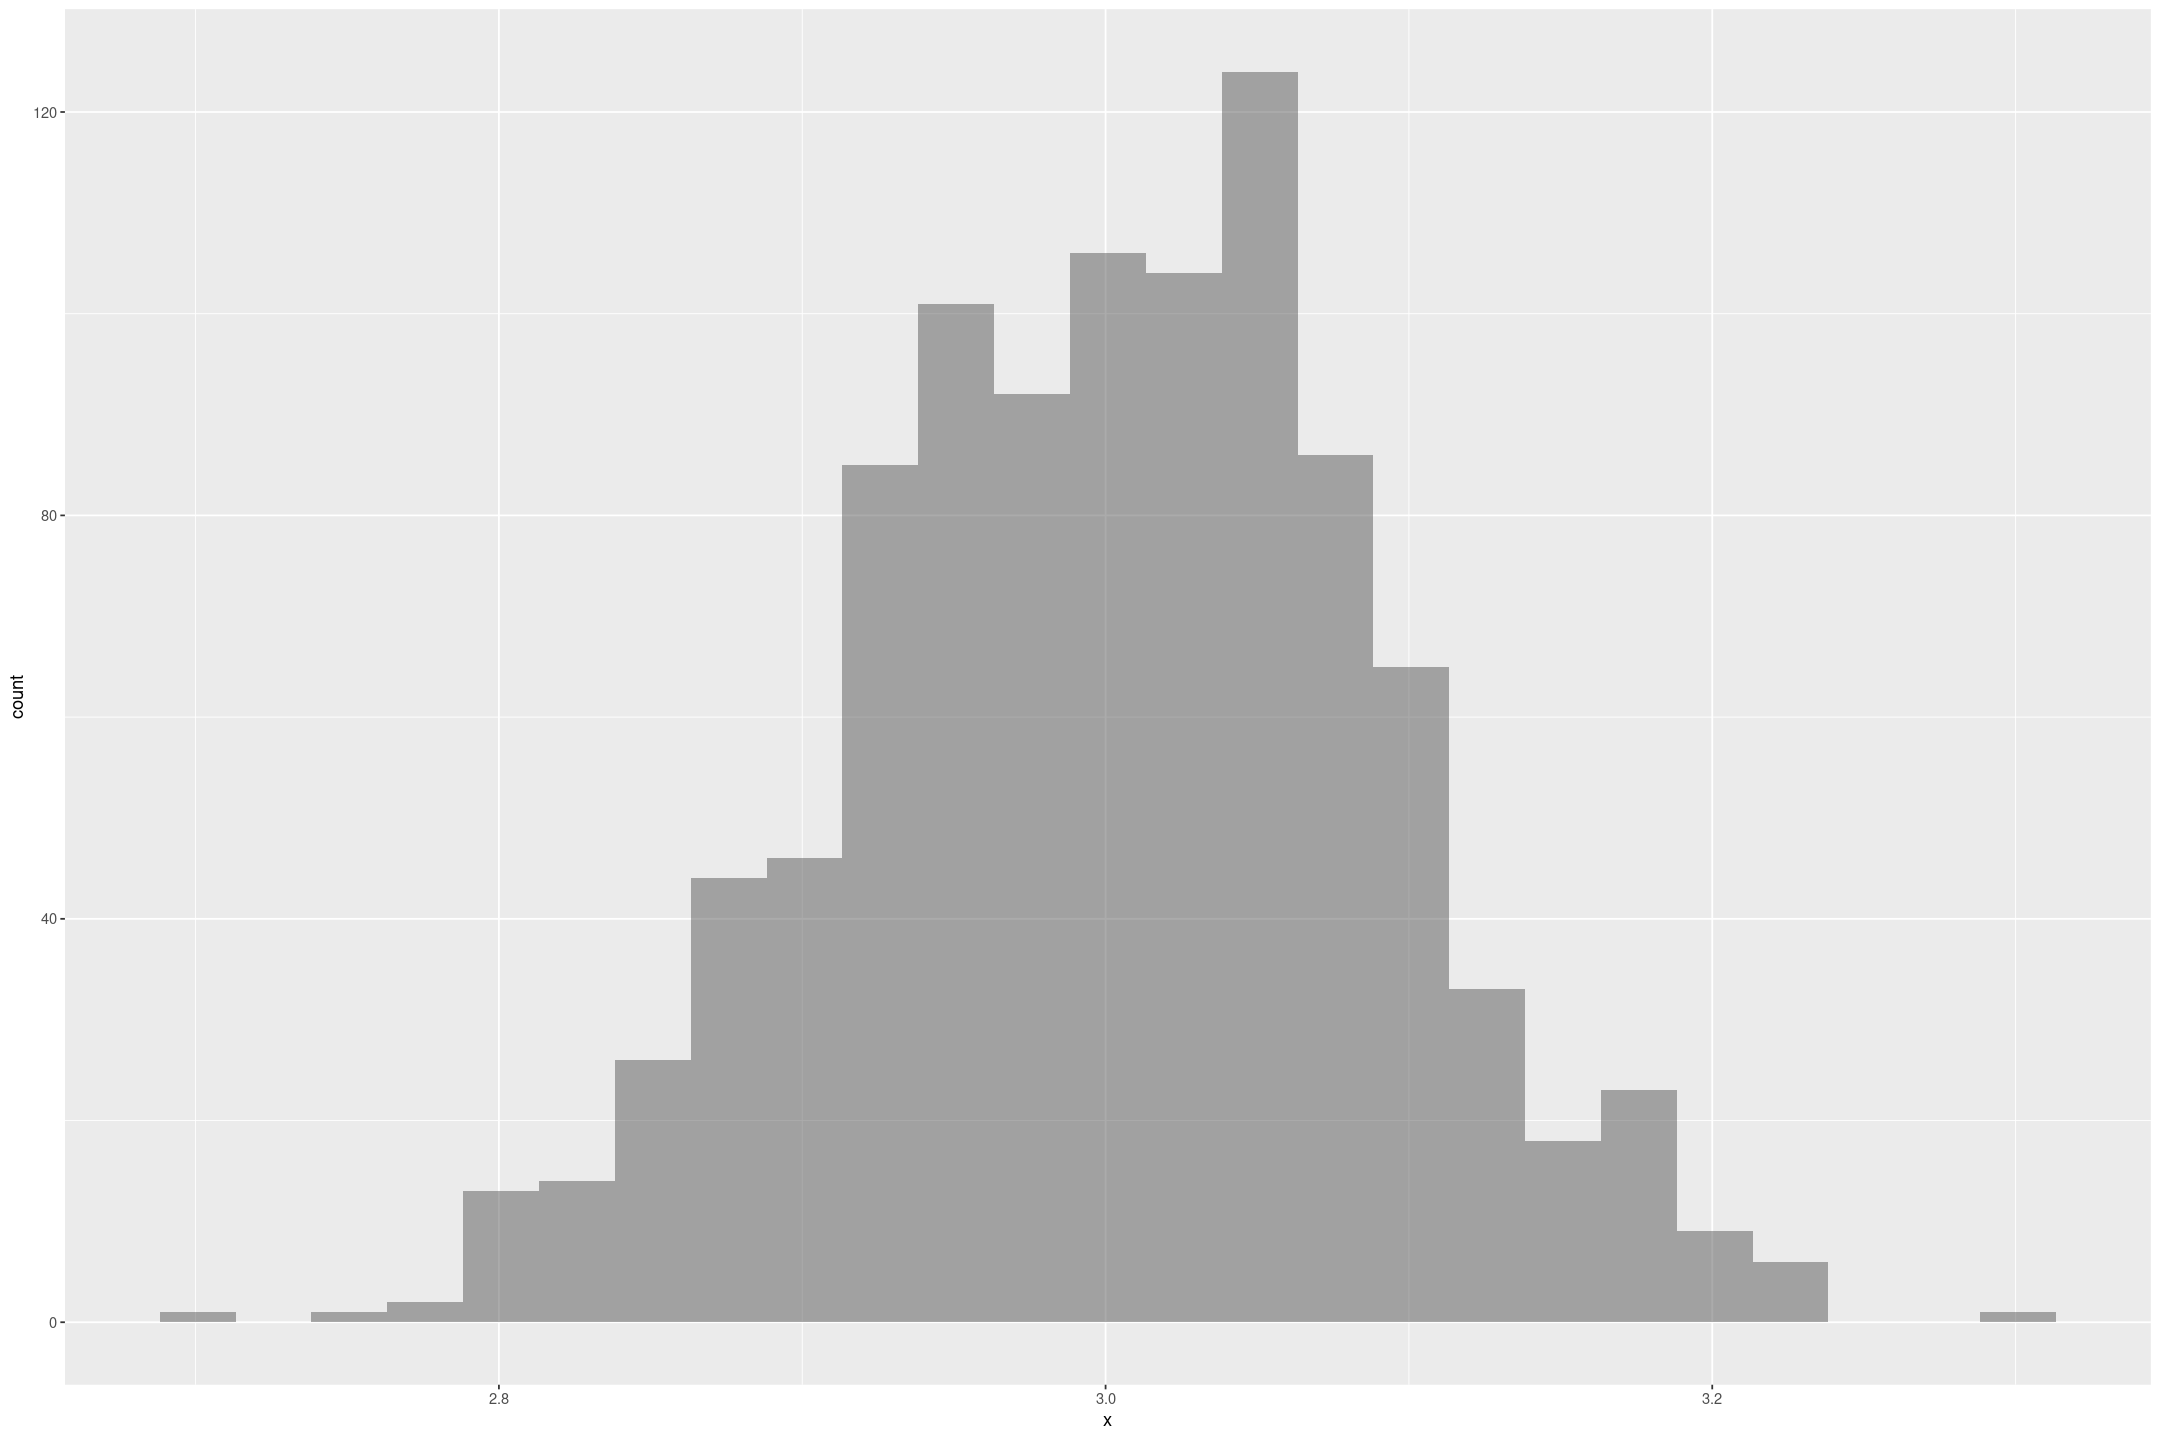

In [162]:
df_sample %>% gf_histogram(~x)

The average value is very close to the true value of 3

In [163]:
mean(df_sample$x)

[1] 3.003074

### The intercept

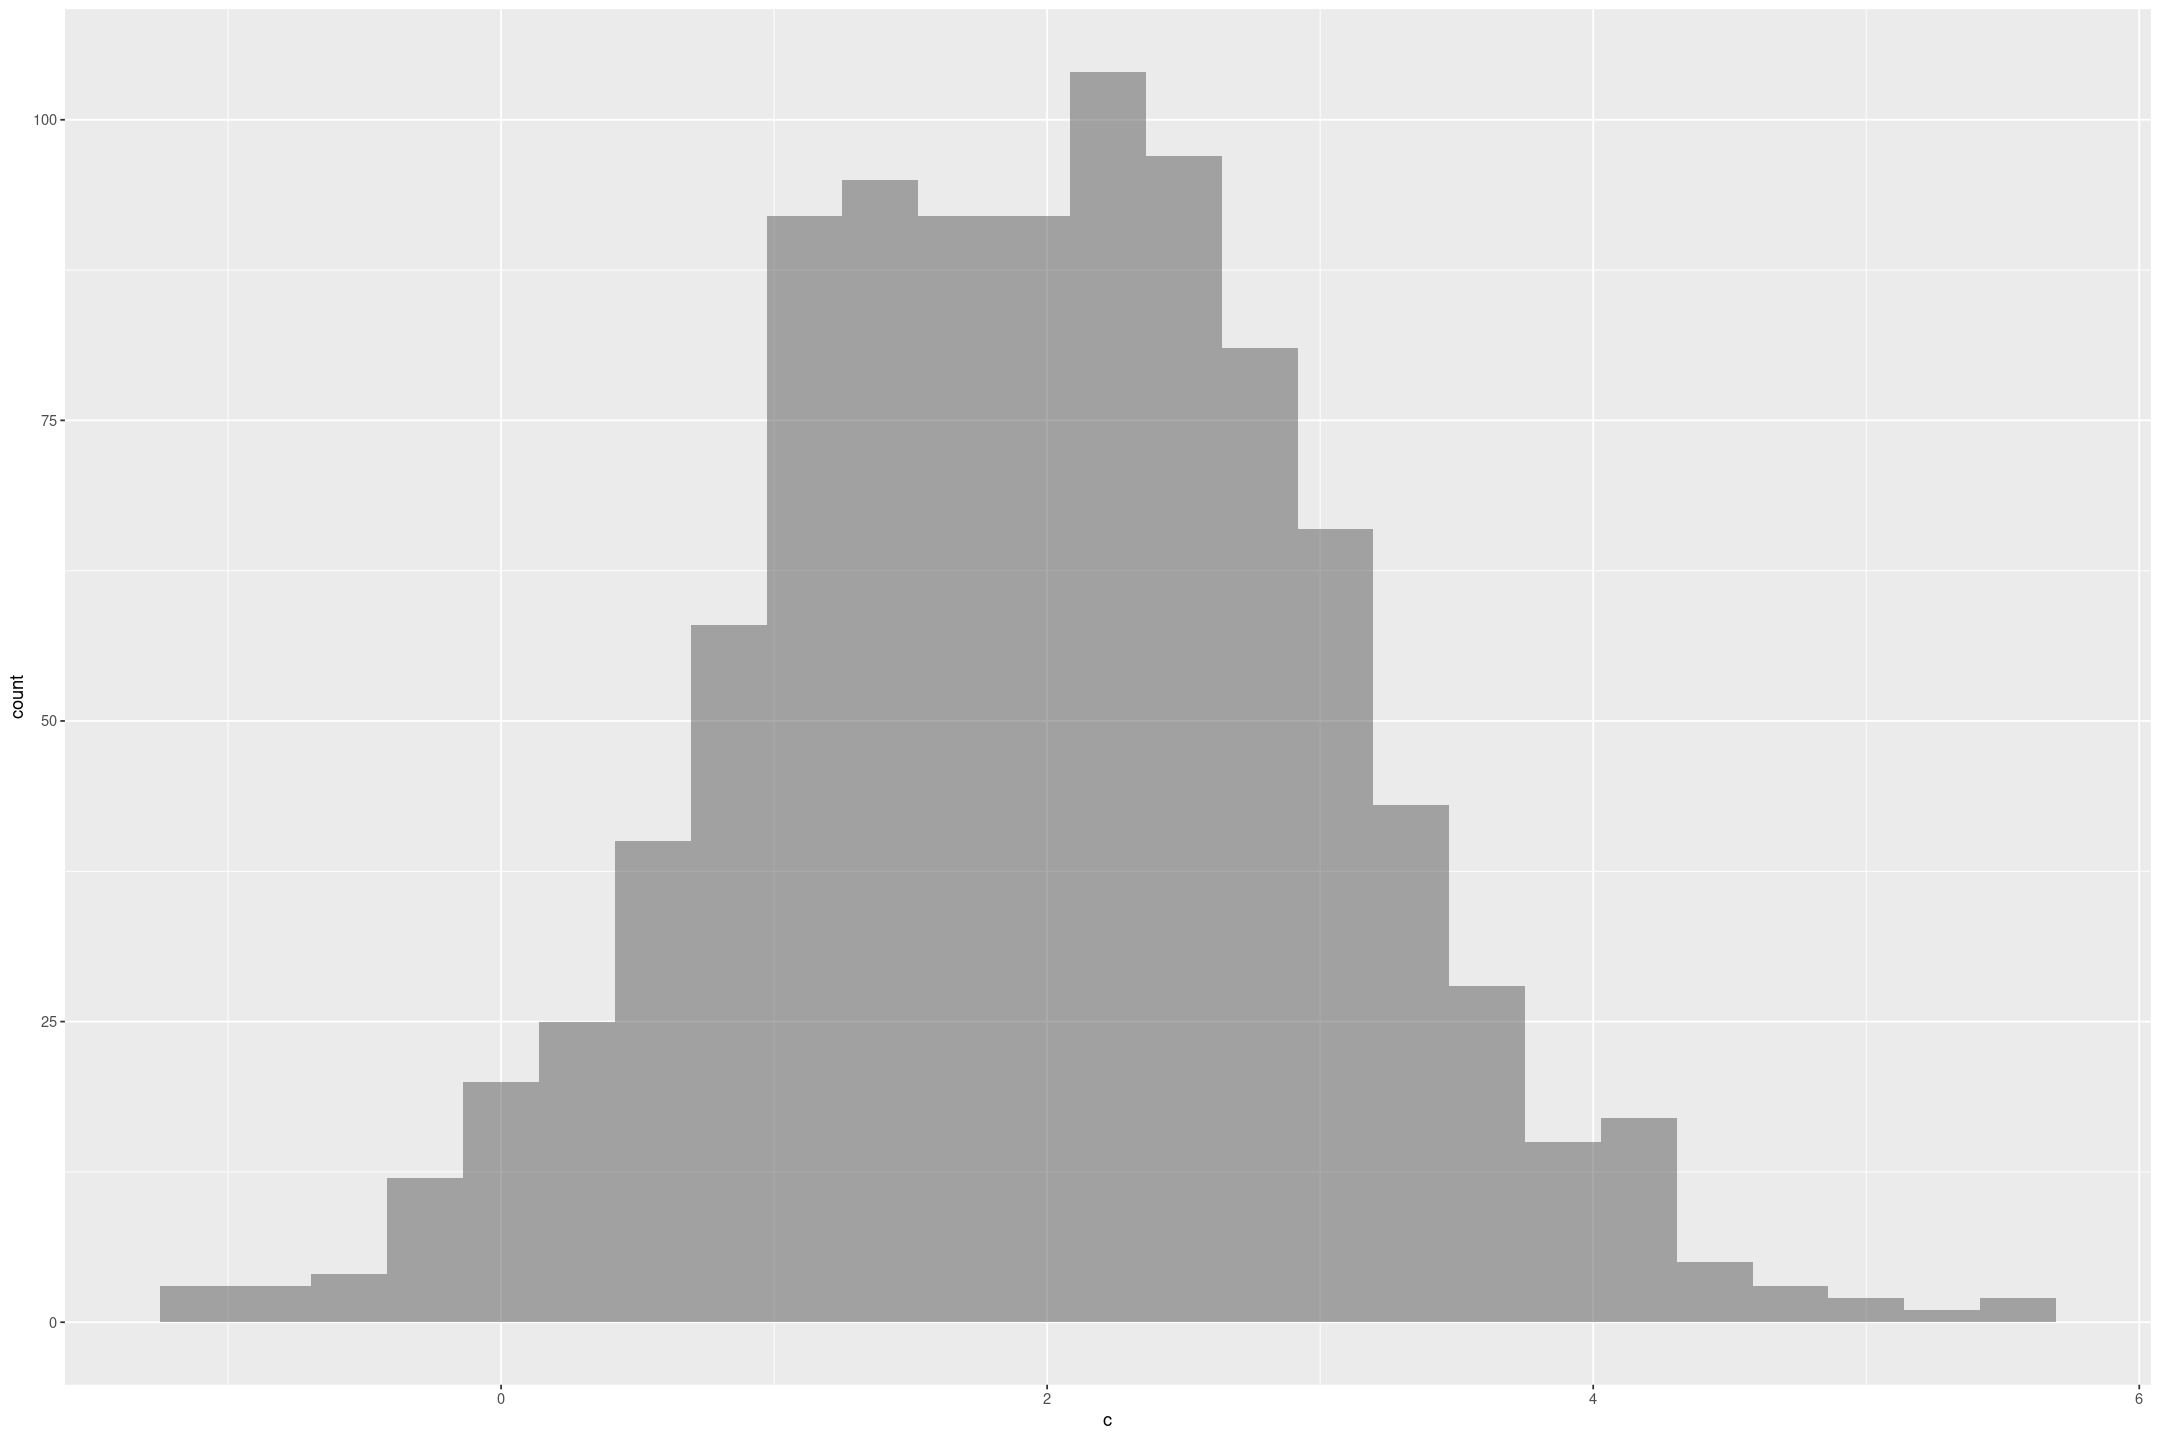

In [164]:
df_sample %>% gf_histogram(~c)

The average value is very close to the true value of 2

In [165]:
mean(df_sample$c)

[1] 1.966662

## Standard Deviation approximates their standard errors

### Slope

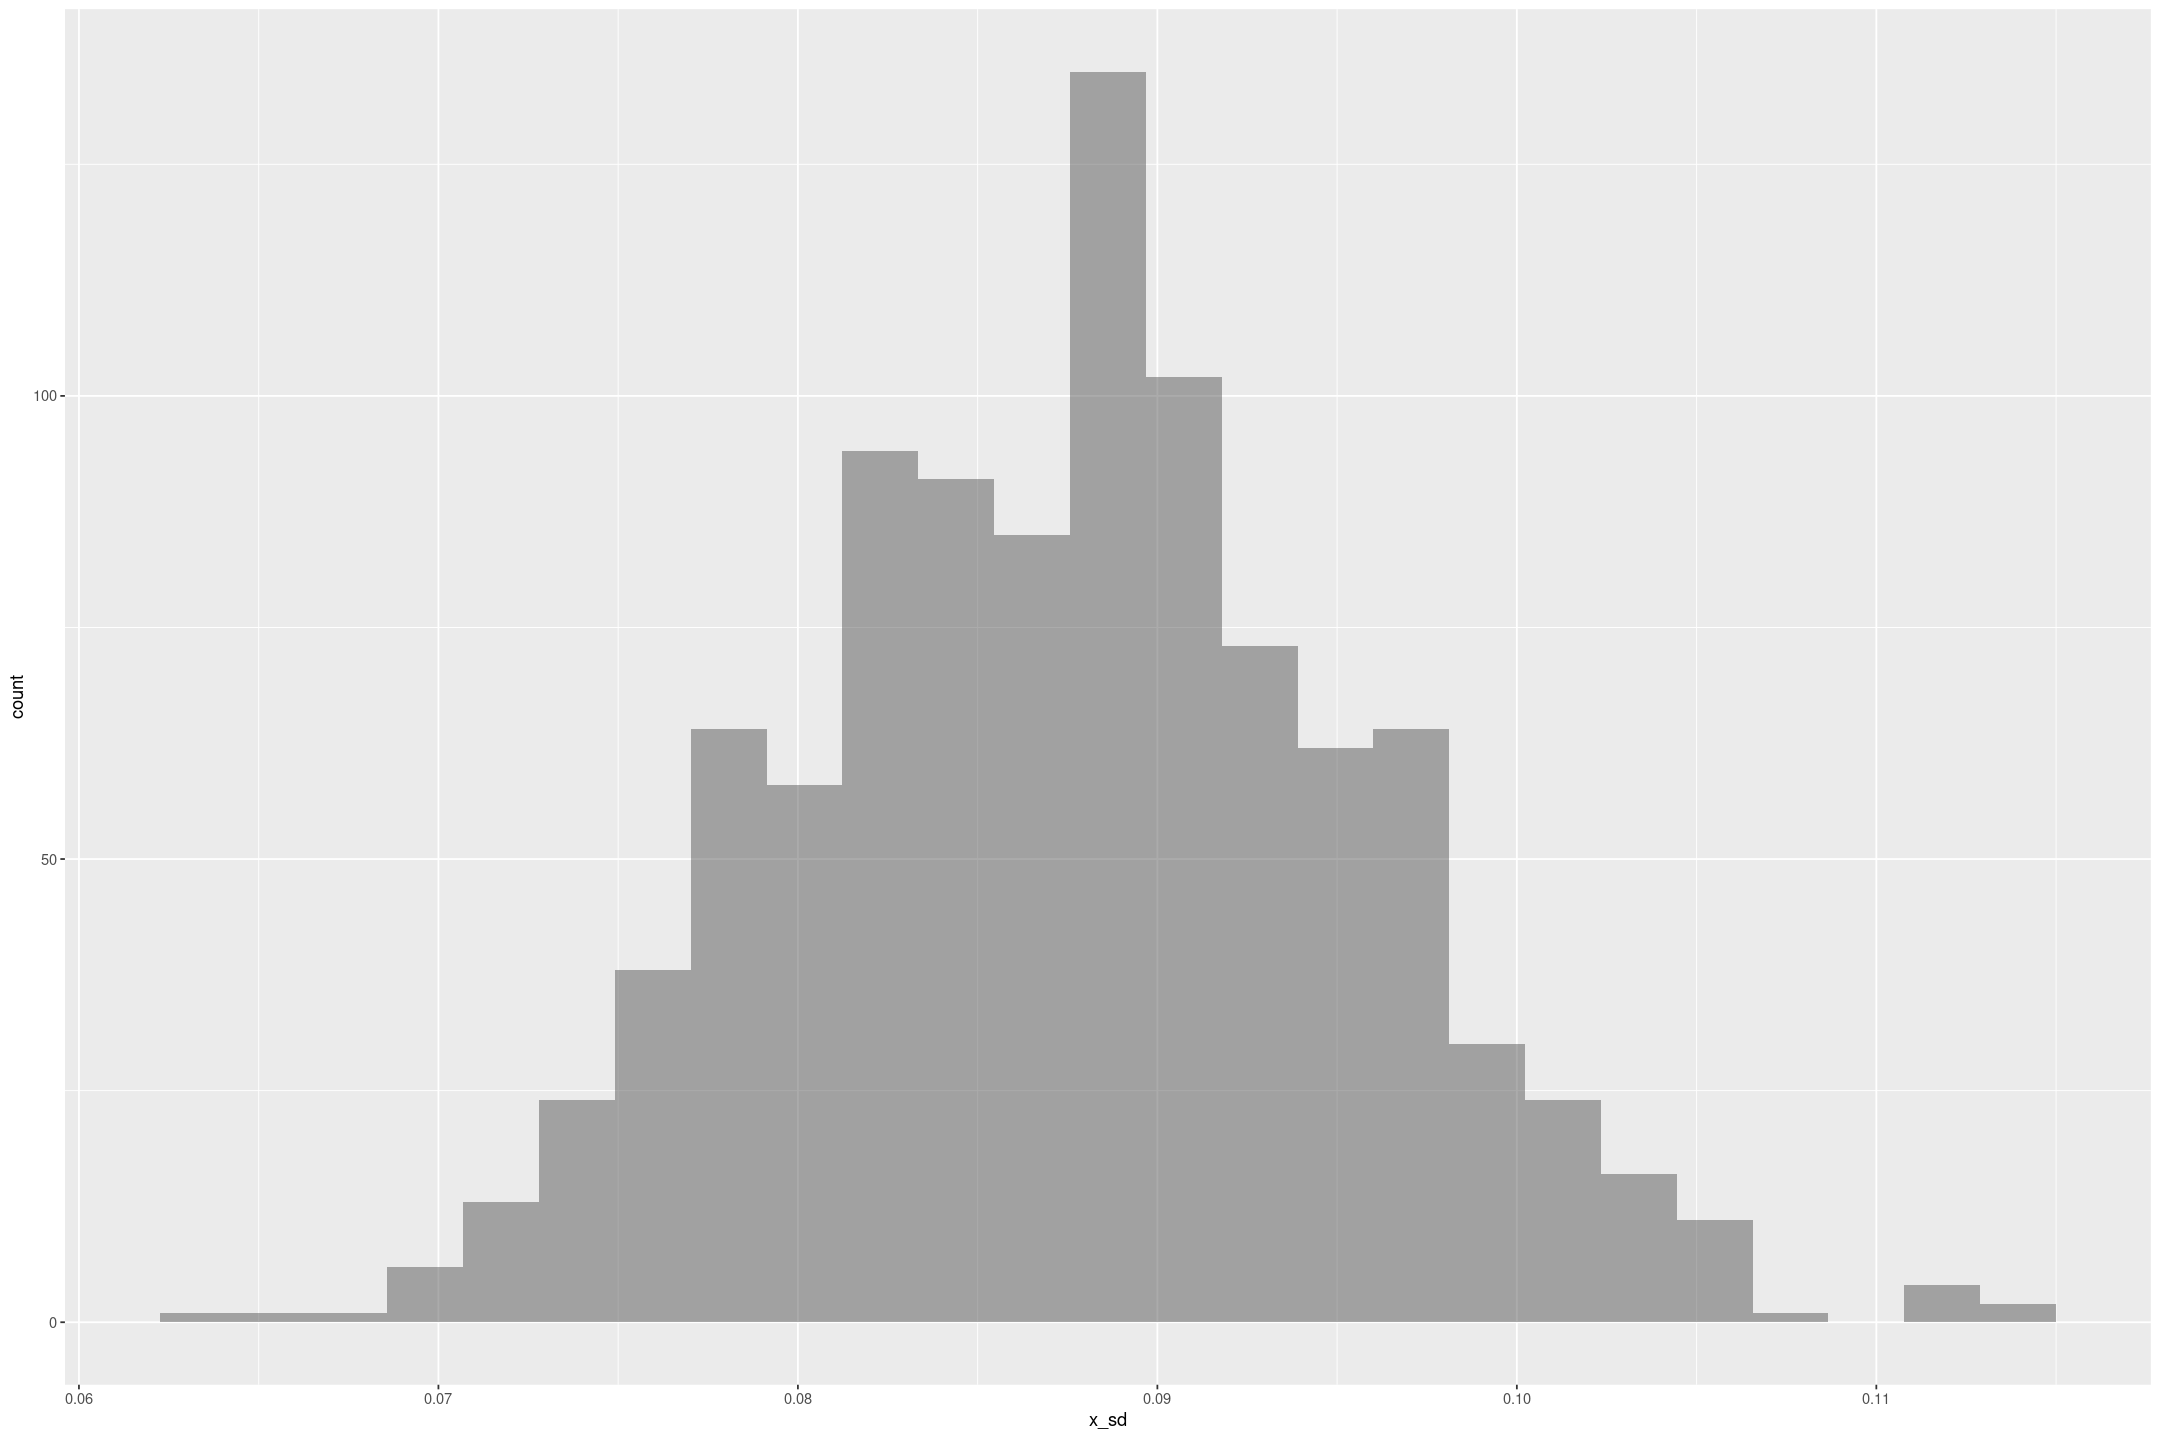

In [166]:
df_sample %>% gf_histogram(~x_sd)

The standard error

In [167]:
sqrt(mean((df_sample$x - 3)^2))

[1] 0.08694087

The standard deviations are good approximations.

In [168]:
mean(df_sample$x_sd)

[1] 0.08773338

### Intercept

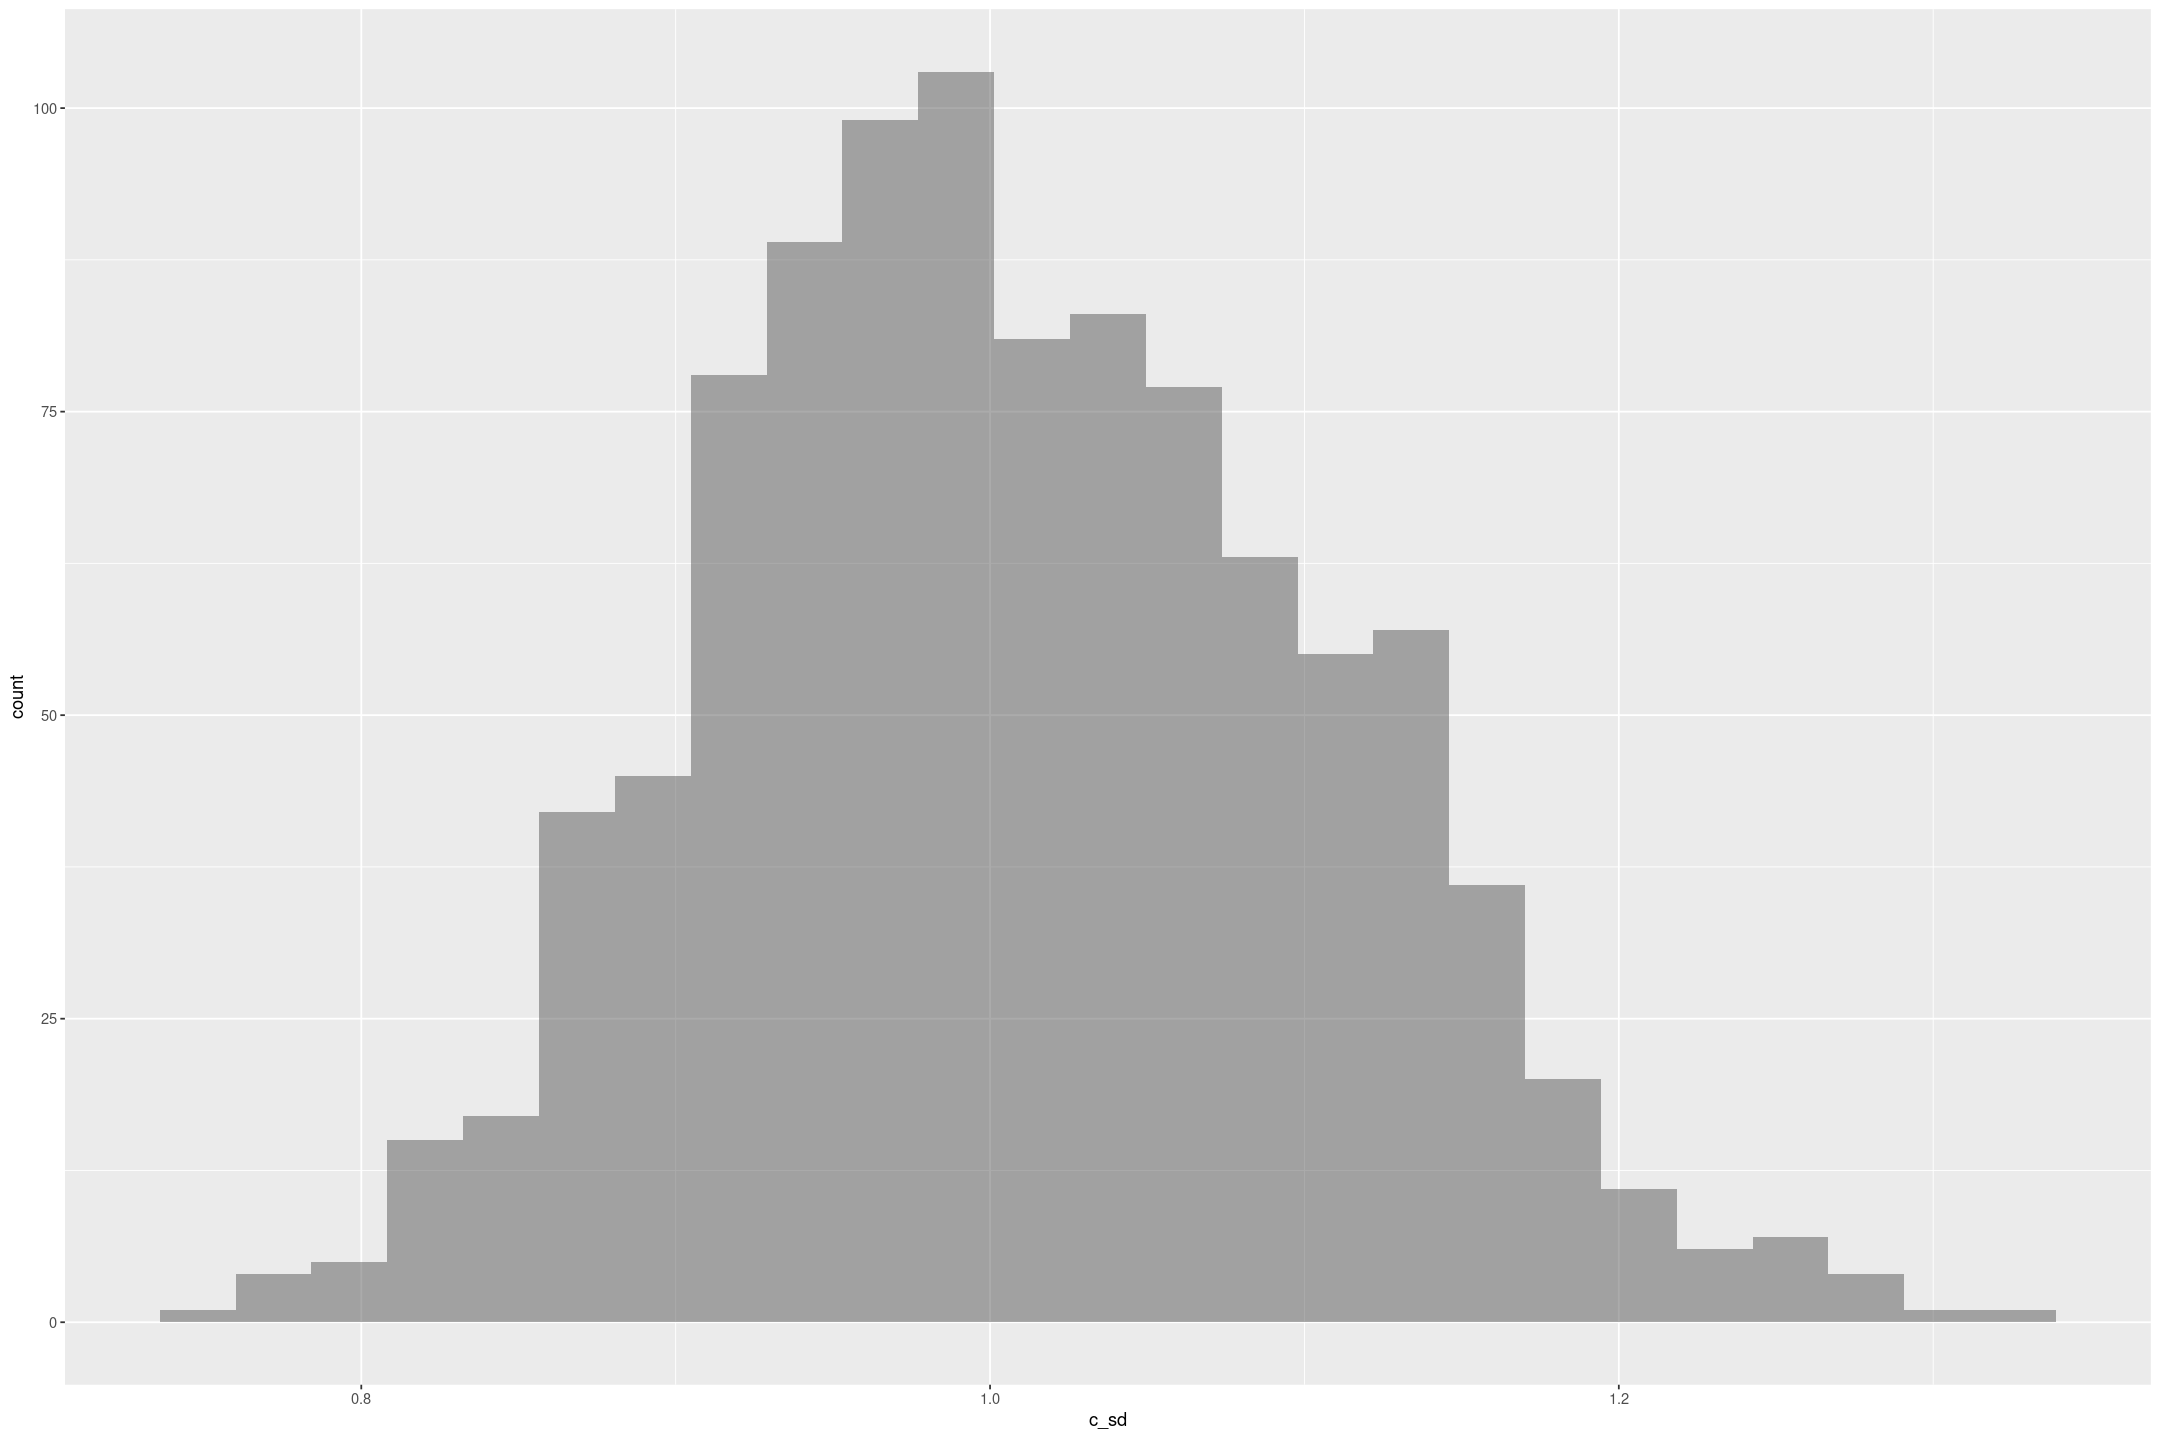

In [169]:
df_sample %>% gf_histogram(~c_sd)

The standard error

In [170]:
sqrt(mean((df_sample$c - 2)^2))

[1] 1.054601

The standard deviations are good approximations.

In [171]:
mean(df_sample$c_sd)

[1] 1.010293

## 95% Coverage

Slope - very close

In [172]:
with(df_sample, (x-2*x_sd < 3) & (x + 2*x_sd > 3)) %>% mean()

[1] 0.946

Intercept - also very close

In [173]:
with(df_sample, (c-2*c_sd < 2) & (c + 2*c_sd > 2)) %>% mean()

[1] 0.938

# Interpretation of Regressions
Redo the election forecasting example of Section 7.1, but switching x and y, that is, predicting economic growth given the subsequent election outcome.
Discuss the problems with giving a causal interpretation to the coefficients in this regression, and consider what this implies about any causal interpreations of the original regression fit in the chapter.

In [174]:
hibbs

year,growth,vote,inc_party_candidate,other_candidate,high_growth
<int>,<dbl>,<dbl>,<fct>,<fct>,<lgl>
1952,2.40,44.60,Stevenson,Eisenhower,TRUE
1956,2.89,57.76,Eisenhower,Stevenson,TRUE
1960,0.85,49.91,Nixon,Kennedy,FALSE
1964,4.21,61.34,Johnson,Goldwater,TRUE
1968,3.02,49.60,Humphrey,Nixon,TRUE
1972,3.62,61.79,Nixon,McGovern,TRUE
1976,1.08,48.95,Ford,Carter,FALSE
1980,-0.39,44.70,Carter,Reagan,FALSE
1984,3.86,59.17,Reagan,Mondale,TRUE


In [175]:
fit0 <- stan_glm(vote ~ growth, data=hibbs, refresh=0)
print(fit0)

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ growth
 observations: 16
 predictors:   2
------
            Median MAD_SD
(Intercept) 46.3    1.6  
growth       3.1    0.7  

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.9    0.7   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Given that vote = 3 * growth + 46.3

We expect growth = 0.3 * vote - 15.
But the result is slightly different to this.

In [176]:
fit <- stan_glm(growth ~ vote, data=hibbs, refresh=0)
print(fit)

stan_glm
 family:       gaussian [identity]
 formula:      growth ~ vote
 observations: 16
 predictors:   2
------
            Median MAD_SD
(Intercept) -7.9    2.3  
vote         0.2    0.0  

Auxiliary parameter(s):
      Median MAD_SD
sigma 1.0    0.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


The model says a 1 percentage point change in the 2 party preferred vote towards the incumbant is associated with a 0.2 percentage point increase in growth since the last election.

Clearly the 2 party preferred vote can't influence economic growth from before the election.
So it doesn't make sense to interpret this causally.
With the original model it's not clear the model is causal; you can't tell just by fitting a line.